# Ninth Exercise (HPO)

This exercise focuses on hyperparameter optimization with neural networks.

We will
- define hyperparameter-configuration search-spaces
- train deep learning models with various hyper parameters
- use random search as a basic hyperparameter optimizer
- use BOHB as an advanced hyperparameter optimizer

It's in the nature of hyperparameter optimization, that you'll have to train a lot of models. 
Therefore execution time will be longer in this exercise, running the completed notebook takes about 30 minutes on a tutor's 3 year old laptop.

#### Install HpBandster and torchvision

You need to install two more python packages for this exercise.

- [torchvision](https://pytorch.org/docs/stable/torchvision/) provides utility methods for pytorch.
- [HpBandSter](https://github.com/automl/HpBandSter) is a fast, parallel implementation of several hyperparameter optimizers.  
   We can define even complex hyperparameter search spaces with [ConfigSpace](https://github.com/automl/ConfigSpace), which comes along HpBandSter as dependency.


Install with anaconda/conda
```
conda install torchvision
conda install hpbandster
```

or with plain python
```
pip3 install torchvision
pip3 install hpbandster
```

In [1]:
!pip3 install hpbandster

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 92kB 6.4MB/s 
     |████████████████████████████████| 972kB 46.5MB/s 
  Created wheel for hpbandster: filename=hpbandster-0.7.4-cp36-none-any.whl size=80007 sha256=8ef8037554707f88f8aedd881c3cc86f392a14912996273c936bb63e786f80c7
  Stored in directory: /root/.cache/pip/wheels/9d/57/62/6b00c8011bac96e0c404adc5be4e16964ba4544614240b4e23
  Created wheel for ConfigSpace: filename=ConfigSpace-0.4.12-cp36-cp36m-linux_x86_64.whl size=2925927 sha256=4c787e16b2c7bda55bd39b91c4fd8e50094e0c64bdc13dc4bb55a25663c8294d
  Stored in directory: /root/.cache/pip/wheels/ae/b2/85/feafec2387f97065d914a72c42ff3a0f6f60d8e1fd03c6bd4b
Successfully built hpbandster ConfigSpace


In [2]:
!pip3 install torchvision

In [0]:
import os
from typing import Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms

# importing optim
import torch.optim as optim

import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torchsummary import summary

# NOT CHANGE!
np.random.seed(0)

def load_mnist_minibatched(batch_size: int, n_train: int = 8192, n_valid: int = 1024,
                           valid_test_batch_size: int = 1024) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_dataset = torchvision.datasets.MNIST(
        root='../data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='../data', train=False, transform=transforms.ToTensor())

    train_sampler = SubsetRandomSampler(range(n_train))
    validation_sampler = SubsetRandomSampler(range(n_train, n_train+n_valid))

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset=train_dataset, batch_size=valid_test_batch_size,
                                   sampler=validation_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=valid_test_batch_size, 
                                              shuffle=False)
    return train_loader, validation_loader, test_loader


def evaluate_accuracy(model: nn.Module, data_loader: DataLoader) -> float:
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in data_loader:
            output = model(x)
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()
    accuracy = correct / len(data_loader.sampler)
    return(accuracy)

## Random Search

Here we get hands on hyperparameter optimization using random search.

### Model and Hyperparameter Space

First we define a configurable model and a hyperparameter space. You learn how to use *ConfigSpace* to define the hyperparameters, by looking at [this example](https://automl.github.io/SMAC3/stable/quickstart.html#using-smac-in-python-svm).   

**Task:** Complete the functions as described in the docstrings.

**Hint:** The `CS.GreaterThanCondition(conditioned_hyperparameter, lefthand_side, righthand_side)` method might be useful.

In [31]:
from collections import OrderedDict

def linear_input_size(image_size, kernel_size, stride, padding):
  return ( (image_size - kernel_size + 2*padding)//stride ) + 1

    
def get_conv_model(num_filters_per_layer: List[int]) -> nn.Module:
    """Builds a deep convolutional model with various number of convolution
       layers for MNIST input using pytorch.
    
    for each element in num_filters_per_layer:
        convolution (conv_kernel_size, num_filters, stride=1, padding=0)
        relu
        max pool    (pool_kernel_size, stride=1)
    linear
    log softmax
    """
    assert len(num_filters_per_layer) > 0, "len(num_filters_per_layer) should be greater than 0"
    pool_kernel_size = 2
    conv_kernel_size = 3
    
    # START TODO ################ (2points)
    class ConvModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.convs = self._make_conv_layers()
        self.fc = nn.Sequential(nn.Linear(in_features= self._calculate_in_features_dim(), out_features=10),
                                nn.LogSoftmax())
      
      def _calculate_in_features_dim(self, image_size=28):
        #grey scale image MNIST (1*28*28)
        input_size = image_size
        for i in range(len(num_filters_per_layer)):
          #stride=1, padding = 0
          size_after_conv = input_size - conv_kernel_size + 1
          #stride=2, max pool
          size_after_pool = size_after_conv//2
          input_size = size_after_pool
        return input_size*input_size*num_filters_per_layer[-1]
      
      def _make_conv_layers(self):
        convs = []
        #grey scale image MNIST (1*28*28)
        input_channel = 1
        for filters in num_filters_per_layer:
          conv = nn.Conv2d(in_channels=input_channel,
                           out_channels=filters,
                           kernel_size=conv_kernel_size,
                           stride=1,
                           padding=0)
          relu = nn.ReLU()
          pool = nn.MaxPool2d(kernel_size=pool_kernel_size)
          convs.extend([conv, relu, pool])
          input_channel = filters

        model = nn.Sequential(*convs)
        return model

      def forward(self, x):
        """
        
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
        # START TODO #############
        x = self.convs(x)
        # Remember to flatten the feature map using:
        # x = x.view(batch_size, dim)
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.fc(x)
        # END TODO #############
        return x

    return ConvModel()

model = get_conv_model([15, 3, 5])
# model.cuda()
summary(model, (1, 28, 28))

    # raise NotImplementedError
    # End TODO ################


def get_configspace() -> CS.ConfigurationSpace:
    """ Define a conditional hyperparameter search-space.
    
    hyperparameters:
      lr              from 1e-6 to 1e-0 (log, float)
      num_filters_1   from    2 to    8 (int)
      num_filters_2   from    2 to    8 (int)
      num_conv_layers from    1 to    2 (int)
    
    conditions: 
      include num_filters_2 only if num_conv_layers > 1
    """
    cs = CS.ConfigurationSpace()
    # START TODO ################ (2points)
    lr = CSH.UniformFloatHyperparameter(name='lr', lower=1e-6, upper=1e-0, log=True)
    num_filters_1 = CSH.UniformIntegerHyperparameter(name='num_filters_1', lower=2, upper=8, default_value=2)
    num_filters_2 = CSH.UniformIntegerHyperparameter(name='num_filters_2', lower=2, upper=8, default_value=2)
    num_conv_layers = CSH.UniformIntegerHyperparameter(name='num_conv_layers', lower=1, upper=2, default_value=1)

    # add the hyperparameters
    cs.add_hyperparameters([lr, num_filters_1, num_filters_2, num_conv_layers])

    # define condition on num_filters_2
    cond1 = CS.GreaterThanCondition(child=num_filters_2, parent=num_conv_layers, value=1)
    cs.add_condition(cond1)
    # raise NotImplementedError
    # End TODO ################
    return cs

cs = get_configspace()
cs

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 26, 26]             150
              ReLU-2           [-1, 15, 26, 26]               0
         MaxPool2d-3           [-1, 15, 13, 13]               0
            Conv2d-4            [-1, 3, 11, 11]             408
              ReLU-5            [-1, 3, 11, 11]               0
         MaxPool2d-6              [-1, 3, 5, 5]               0
            Conv2d-7              [-1, 5, 3, 3]             140
              ReLU-8              [-1, 5, 3, 3]               0
         MaxPool2d-9              [-1, 5, 1, 1]               0
           Linear-10                   [-1, 10]              60
       LogSoftmax-11                   [-1, 10]               0
Total params: 758
Trainable params: 758
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Configuration space object:
  Hyperparameters:
    lr, Type: UniformFloat, Range: [1e-06, 1.0], Default: 0.001, on log-scale
    num_conv_layers, Type: UniformInteger, Range: [1, 2], Default: 1
    num_filters_1, Type: UniformInteger, Range: [2, 8], Default: 2
    num_filters_2, Type: UniformInteger, Range: [2, 8], Default: 2
  Conditions:
    num_filters_2 | num_conv_layers > 1

### Run model with configuration

A single sample from your hyperparameter space is a *Configuration*. You can use the configuration similar to a dictionary, it supports *config.keys(), config.values(), value = config[key], key in config, …* .
You can iterate a *DataLoader* to access (data, label) batches.

**Note:** If a condition isn't met, the conditional hyperparameter isn't included in the configuration.

**Task:** Complete the function to run a model like defined by the configuration. The function should return the model and the *validation error* for each epoch. You can use *evaluate_accuracy* (defined above), don't forget to switch between train and eval mode.

In [0]:
def run_conv_model(config: CS.Configuration, epochs: int, train_loader: DataLoader,
                   validation_loader: DataLoader) -> Tuple[nn.Module, List[float]]:    
    """ Run and evaluate a model from get_conv_model with NLLLoss and SGD.
    """
    # START TODO ################ (3points)
    # retrieve the number of filters from the config and create the model
    lr = config['lr']
    num_conv_layers = config['num_conv_layers']
    num_filters_1 = config['num_filters_1']
    if (num_conv_layers > 1):
      num_filters_2 = config['num_filters_2']
      num_filters_per_layer = [num_filters_1, num_filters_2]
    else:
      num_filters_per_layer = [num_filters_1]
    # get model
    model = get_conv_model(num_filters_per_layer)

    # Define a Loss function and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    val_errors = []

    # train the network
    for epoch in range(epochs):
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          if i % 1000 == 999:    # print every 1000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
              running_loss = 0.0
      
      # get val_errors
      val_accuracy = evaluate_accuracy(model, data_loader=validation_loader)
      val_errors.append(1-val_accuracy)
    
    # raise NotImplementedError
    # End TODO ################
    return model, val_errors

In [33]:
train_loader, validation_loader, _ = load_mnist_minibatched(batch_size=5)
cs = get_configspace()
config = cs.sample_configuration()
model, val_errors = run_conv_model(config, epochs=5, train_loader=train_loader, validation_loader=validation_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[1,  1000] loss: 0.317
[2,  1000] loss: 0.138
[3,  1000] loss: 0.099
[4,  1000] loss: 0.077
[5,  1000] loss: 0.059


Text(0.5, 1.0, 'val erros')

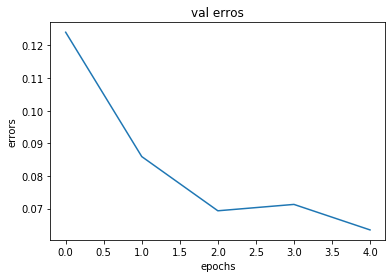

In [34]:
plt.plot(val_errors)
plt.xlabel("epochs")
plt.ylabel("errors")
plt.title("val erros")

Now let's run models with various, random hyperparameter configurations. Don't forget to store all the configuration and validation errors for further evaluation.

**Tipp:** *ConfigSpace* objects have a *.sample_configuration()* function to sample a random configuration.

**Task:** Run *n_random_samples* models for *n_epochs* and store the tuple `(model, config, val_errors)` in `results`.

In [35]:
n_random_samples = 18
n_epochs = 9
cs = get_configspace()
train_loader, validation_loader, _ = load_mnist_minibatched(batch_size=32, n_train=4096, n_valid=512)


# START TODO ################ (1point)
results = []
for n in range(n_random_samples):
  config = cs.sample_configuration()
  model,val_errors = run_conv_model(config=config, 
                                    epochs=n_epochs, 
                                    train_loader=train_loader, 
                                    validation_loader=validation_loader)
  results.append((model, config, val_errors))
# raise NotImplementedError
# End TODO ################

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [36]:
np.shape(results)
results[2]

(ConvModel(
   (convs): Sequential(
     (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc): Sequential(
     (0): Linear(in_features=100, out_features=10, bias=True)
     (1): LogSoftmax()
   )
 ), Configuration:
   lr, Value: 0.0007934823797450013
   num_conv_layers, Value: 2
   num_filters_1, Value: 4
   num_filters_2, Value: 4, [0.859375,
  0.82421875,
  0.765625,
  0.626953125,
  0.47265625,
  0.375,
  0.23046875,
  0.166015625,
  0.138671875])

### Evaluate 

Now we should evaluate the previous runs. Evaluation in hyperparameter optimization can mean two different things: On the one hand, we might be only interested in the model with the best performance. On the other hand, we might want to find the best hyperparameter configuration to then train a model with these hyper-parameters (but with e.g. more epochs).

**Task:** Print the model and final validation error of the best model in `results`.

In [37]:
# START TODO ################ (1point)
final_val_error = [r[2][-1] for r in results]
print(f'final_val_error shape: {len(final_val_error)}')
best_model_index = np.argmin(final_val_error)
val_error_best_model = results[best_model_index][2]
val_error_best_model = val_error_best_model[-1]
print(f'best model: {results[best_model_index][0]}, validation error for best model: {val_error_best_model}')
# raise NotImplementedError
# END TODO ################

final_val_error shape: 18
best model: ConvModel(
  (convs): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 5, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=125, out_features=10, bias=True)
    (1): LogSoftmax()
  )
), validation error for best model: 0.044921875


Let's further investigate which hyperparameters work well and which don't.

**Task:** Print a scatter plot of learning rate (x) and number of filters (sum over layers, y). Scale the size of the scatter points by the error in the last epoch (10 to 100).

lr size:(18,), num_filters shape:(18,)


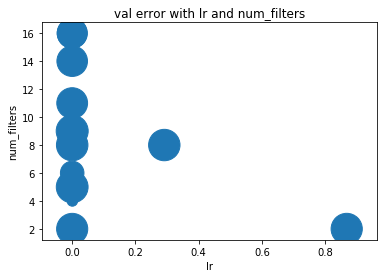

In [38]:
# START TODO ################ (2points)
# raise NotImplementedError
# results[2]
lr = []
num_filters = []
final_val_error = []
for r in results:
  config = r[1]
  lr.append(config['lr'])

  num_conv_layers = config['num_conv_layers']
  num_filters_1 = config['num_filters_1']
  num_filters_2 = 0
  if (num_conv_layers > 1):
    num_filters_2 = config['num_filters_2']
  num_filters.append(num_filters_1 + num_filters_2)
  final_val_error.append(r[2][-1])
min_error = min(final_val_error)
final_val_error = [50*s//min_error for s in final_val_error]
plt.scatter(x=lr, y=num_filters, s=final_val_error)
plt.xlabel('lr')
plt.ylabel('num_filters')
plt.title("val error with lr and num_filters")
print(f'lr size:{np.shape(lr)}, num_filters shape:{np.shape(num_filters)}')

# END TODO ################

**Question:** What pattern do you see? Why might it occur? (1point)

**Answer:** **TODO** The validation error is lower, for higher learning rates. The number of filters doesn't affect it. We evaluate only after a short training (9 epochs), small learning rates converge not fast enough and high capacity isn't necessary.

After looking at the final error, let's now have a look at the training error.

**Task:** Plot error curves (error per epoch) for all your configurations in one figure.

Text(0, 0.5, 'error')

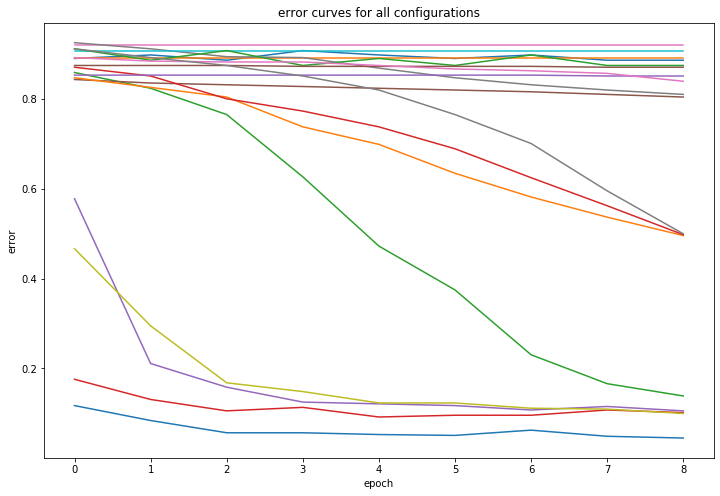

In [41]:
# START TODO ################ (1point)
# raise NotImplementedError
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
for r in results:
  error_current_config = r[2]
  ax.plot(error_current_config)
ax.set_title('error curves for all configurations')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
# END TODO ################

**Questions:** How could you detect configurations with a low error earlier/faster? Why could this be problematic? 

**Answers:** **TODO** Learning curves with low error at the end usually have low error at earlier epochs. We could evaluate the error after only a few epochs (also possible: they are steeper). This might be problematic, because the best curve after a few epochs is not necessarily the best one after all epochs.
Therefore early evaluation might help filtering out poor configurations but may not find the best configuration.

## BOHB

Here we will use the more advanced hyperparameter optimizer [BOHB](https://www.automl.org/blog_bohb/) (Bayesian Optimization with Hyperband).
Based on TPE and [Hyperband](https://arxiv.org/pdf/1603.06560.pdf), BOHB evaluates configurations on your model with increasing budgets. In the context of Deep Learning, budget can be the number of epochs or the number of training samples. In lower budget evaluations, BOHB can look at more configurations. Full budget evaluations avoid missing configurations which are poor at the beginnning but good at the end (and vice versa). 
At the start of a run, BOHB samples configurations randomly. After some time, BOHB then uses a bayesian model (based on Parzen Tree Estimators), sampling only promising configs.

This exercise part is based on the [HpBandSter Examples](https://automl.github.io/HpBandSter/build/html/auto_examples/index.html) and the [HpBandSter Documentation](https://automl.github.io/HpBandSter/). *HpBandSter* provides a fast implementation of *Randomsearch*, *Hyperband* and *BOHB*. The optimization can easily be distributed between multiple cores or even multiple computers.

In [0]:
import pickle
import logging

from hpbandster.core.worker import Worker
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB

logging.getLogger('hpbandster').setLevel(logging.DEBUG)

### Implement Worker

The worker defines the hyperparameter problem which we try to optimize.
*compute(...)* should - for a given configuration and budget - return a loss which the hyperparameter optimizer tries to minimize. In our case, we can use the number of epochs as budget and the validation error as loss. 
As best practice, we define the configuration space also in the worker.

If you need help, you might get some inspiration from the [HpBandSter Pytorch Worker Example](https://automl.github.io/HpBandSter/build/html/auto_examples/example_5_pytorch_worker.html#sphx-glr-auto-examples-example-5-pytorch-worker-py).

**Task:** Complete the methods below.

In [0]:
class PyTorchWorker(Worker):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.train_loader, self.validation_loader, self.test_loader =\
            load_mnist_minibatched(batch_size=32, n_train=4096, n_valid=512)

    @staticmethod
    def get_model(config: CS.Configuration) -> nn.Module:
        """ Define a configurable convolution model.
            
        See description of get_conv_model above for more details on the model.
        """
        # START TODO ################ (1point)
        # raise NotImplementedError
        num_filters_per_layer = [config[k] for k in sorted(config.keys()) if k.startswith('num_filters')]
        return get_conv_model(num_filters_per_layer)
        # END TODO ################
        
    @staticmethod
    def get_configspace() -> CS.Configuration:
        """ Define a conditional hyperparameter search-space.
    
        hyperparameters:
          num_filters_1   from    4 to   32 (int)
          num_filters_2   from    4 to   32 (int)
          num_filters_3   from    4 to   32 (int)
          num_conv_layers from    1 to    3 (int)
          lr              from 1e-6 to 1e-1 (float, log)
          sgd_momentum    from 0.00 to 0.99 (float)
          optimizer            Adam or  SGD (categoric)
          
        conditions: 
          include num_filters_2 only if num_conv_layers > 1
          include num_filters_3 only if num_conv_layers > 2
          include sgd_momentum  only if       optimizer = SGD
        """
        # START TODO ################ (2points)
        # raise NotImplementedError
        cs = CS.ConfigurationSpace()
        lr = CSH.UniformFloatHyperparameter('lr', lower=1e-6, upper=1e-1, default_value='1e-2', log=True)

        # SGD has a different parameter 'momentum'.
        optimizer = CSH.CategoricalHyperparameter('optimizer', ['Adam', 'SGD'])
        sgd_momentum = CSH.UniformFloatHyperparameter('sgd_momentum', lower=0.0, upper=0.99, default_value=0.9, log=False)
        cs.add_hyperparameters([lr, optimizer, sgd_momentum])

        # The hyperparameter sgd_momentum will be used,if the configuration
        # contains 'SGD' as optimizer.
        cond = CS.EqualsCondition(sgd_momentum, optimizer, 'SGD')
        cs.add_condition(cond)

        num_conv_layers =  CSH.UniformIntegerHyperparameter('num_conv_layers', lower=1, upper=3, default_value=2)

        num_filters_1 = CSH.UniformIntegerHyperparameter('num_filters_1', lower=4, upper=32, default_value=16, log=True)
        num_filters_2 = CSH.UniformIntegerHyperparameter('num_filters_2', lower=4, upper=32, default_value=16, log=True)
        num_filters_3 = CSH.UniformIntegerHyperparameter('num_filters_3', lower=4, upper=32, default_value=16, log=True)


        cs.add_hyperparameters([num_conv_layers, num_filters_1, num_filters_2, num_filters_3])

        # You can also use inequality conditions:
        cond = CS.GreaterThanCondition(num_filters_2, num_conv_layers, 1)
        cs.add_condition(cond)

        cond = CS.GreaterThanCondition(num_filters_3, num_conv_layers, 2)
        cs.add_condition(cond)

        return cs
        # END TODO ################

    def compute(self, config: CS.Configuration, budget: float, working_directory: str,
                *args, **kwargs) -> dict:
        """Evaluate a function with the given config and budget and return a loss.
        
        Bohb tries to minimize the returned loss.
        
        In our case the function is the training and validation of a model,
        the budget is the number of epochs and the loss is the validation error.
        """
        model = self.get_model(config)
        summary(model, (1, 28, 28))
        
        # START TODO ################ (3points)
        # Define a Loss function and optimizer
        criterion = nn.NLLLoss()
        
        if (config['optimizer'] == 'Adam'):
          optimizer = optim.Adam(params=model.parameters(), lr=config['lr'])

        else:
          optimizer = optim.SGD(params=model.parameters(), lr=config['lr'], momentum=config['sgd_momentum'])

        # train the network
        for epoch in range(int(budget)):
          running_loss = 0.0
          for i, data in enumerate(self.train_loader, 0):
              inputs, labels = data
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()
              if i % 1000 == 999:    # print every 1000 mini-batches
                  print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 2000))
                  running_loss = 0.0

        # raise NotImplementedError
        # END TODO ################
        
        train_accuracy = evaluate_accuracy(model, self.train_loader)
        validation_accuracy = evaluate_accuracy(model, self.validation_loader)
        test_accuracy = evaluate_accuracy(model, self.test_loader)
        
        return ({
                'loss': 1 - validation_accuracy,  # remember: HpBandSter minimizes the loss!
                'info': {'test_accuracy': test_accuracy,
                         'train_accuracy': train_accuracy,
                         'valid_accuracy': validation_accuracy,
                         'model': str(model)}
                })

   

It's best practice to do a quick sanity check of our worker with a low budget:

In [0]:
working_dir = os.curdir
# minimum budget that BOHB uses
min_budget = 1
# largest budget BOHB will use
max_budget = 9

In [72]:
worker = PyTorchWorker(run_id='0')
cs = worker.get_configspace()

config = cs.sample_configuration().get_dictionary()
print(config)

res = worker.compute(config=config, budget=min_budget, working_directory=working_dir)
print(res)

{'lr': 2.9260716982315987e-05, 'num_conv_layers': 2, 'num_filters_1': 15, 'optimizer': 'Adam', 'num_filters_2': 9}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 26, 26]             150
              ReLU-2           [-1, 15, 26, 26]               0
         MaxPool2d-3           [-1, 15, 13, 13]               0
            Conv2d-4            [-1, 9, 11, 11]           1,224
              ReLU-5            [-1, 9, 11, 11]               0
         MaxPool2d-6              [-1, 9, 5, 5]               0
            Linear-7                   [-1, 10]           2,260
        LogSoftmax-8                   [-1, 10]               0
Total params: 3,634
Trainable params: 3,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.01
Estimated Total Size (MB): 0

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


{'loss': 0.771484375, 'info': {'test_accuracy': 0.2187, 'train_accuracy': 0.23779296875, 'valid_accuracy': 0.228515625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(15, 9, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=225, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}


### Run BOHB

We now run the hyperparameter search with BOHB and the worker which we defined above and save the result to disk. 
Try to understand what happens. *HpBandSter* allows to start additional workers on the same or remote devices to parallelize the executions, that's why we need to setup some network stuff (nameserver, nic, host, port, …). If you're interested, you can check this out in the [HpBandSter Examples](https://automl.github.io/HpBandSter/build/html/auto_examples/index.html), but it is beyond the scope of this exercise.

**Note:** The code below will try 60 different configurations. Some of them are executed at multiple budgets, which results in about 80 model training. Therefore it might take a while (15-45 minutes on a laptop). If you are interested in how BOHB works, checkout [BOHB (Falkner et al. 2018)](http://proceedings.mlr.press/v80/falkner18a.html).

**Note 2:** You can see the progress in the debug output below. The configuration identifier (called `config_id` in the docs) is a three-tuple `(current iteration, resampling in case of error, sample)`. 

In [0]:
result_file = os.path.join(working_dir, 'bohb_result.pkl')
nic_name = 'lo'
port = 0
run_id = 'bohb_run_1'
n_bohb_iterations = 12

In [74]:
try:
    # Start a nameserver
    host = hpns.nic_name_to_host(nic_name)
    ns = hpns.NameServer(run_id=run_id, host=host, port=port,
                         working_directory=working_dir)
    ns_host, ns_port = ns.start()

    # Start local worker
    w = PyTorchWorker(run_id=run_id, host=host, nameserver=ns_host,
                      nameserver_port=ns_port, timeout=120)
    w.run(background=True)

    # Run an optimizer
    bohb = BOHB(configspace=worker.get_configspace(),
                run_id=run_id,
                host=host,
                nameserver=ns_host,
                nameserver_port=ns_port,
                min_budget=min_budget, max_budget=max_budget)

    result = bohb.run(n_iterations=n_bohb_iterations)
    print("Write result to file {}".format(result_file))
    with open(result_file, 'wb') as f:
        pickle.dump(result, f)
finally:
    bohb.shutdown(shutdown_workers=True)
    ns.shutdown()

12:14:36 wait_for_workers trying to get the condition
12:14:36 WORKER: Connected to nameserver <Pyro4.core.Proxy at 0x7fcc4e802d68; connected IPv4; for PYRO:Pyro.NameServer@127.0.0.1:39719>
12:14:36 WORKER: No dispatcher found. Waiting for one to initiate contact.
12:14:36 WORKER: start listening for jobs
12:14:36 DISPATCHER: started the 'discover_worker' thread
12:14:36 DISPATCHER: started the 'job_runner' thread
12:14:36 DISPATCHER: Pyro daemon running on 127.0.0.1:42119
12:14:36 HBMASTER: only 0 worker(s) available, waiting for at least 1.
12:14:36 DISPATCHER: Starting worker discovery
12:14:36 DISPATCHER: Found 1 potential workers, 0 currently in the pool.
12:14:36 DISPATCHER: discovered new worker, hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944
12:14:36 HBMASTER: number of workers changed to 1
12:14:36 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
12:14:36 adjust_queue_size: lock accquired
12:14:36 HBMASTER: adjusted queue size to (0, 1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
              ReLU-2            [-1, 6, 26, 26]               0
         MaxPool2d-3            [-1, 6, 13, 13]               0
            Conv2d-4            [-1, 4, 11, 11]             220
              ReLU-5            [-1, 4, 11, 11]               0
         MaxPool2d-6              [-1, 4, 5, 5]               0
            Linear-7                   [-1, 10]           1,010
        LogSoftmax-8                   [-1, 10]               0
Total params: 1,290
Trainable params: 1,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.00
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


12:14:40 WORKER: done with job (0, 0, 0), trying to register it.
12:14:40 WORKER: registered result for job (0, 0, 0) with dispatcher
12:14:40 DISPATCHER: job (0, 0, 0) finished
12:14:40 DISPATCHER: register_result: lock acquired
12:14:40 DISPATCHER: job (0, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:14:40 job_id: (0, 0, 0)
kwargs: {'config': {'lr': 6.953360763749845e-06, 'num_conv_layers': 2, 'num_filters_1': 6, 'optimizer': 'Adam', 'num_filters_2': 4}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.935546875, 'info': {'test_accuracy': 0.0643, 'train_accuracy': 0.067138671875, 'valid_accuracy': 0.064453125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2, stride=2, pad

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
         MaxPool2d-3            [-1, 4, 13, 13]               0
            Linear-4                   [-1, 10]           6,770
        LogSoftmax-5                   [-1, 10]               0
Total params: 6,810
Trainable params: 6,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.03
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


12:14:42 WORKER: done with job (0, 0, 1), trying to register it.
12:14:42 WORKER: registered result for job (0, 0, 1) with dispatcher
12:14:42 DISPATCHER: job (0, 0, 1) finished
12:14:42 DISPATCHER: register_result: lock acquired
12:14:42 DISPATCHER: job (0, 0, 1) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:14:42 job_id: (0, 0, 1)
kwargs: {'config': {'lr': 2.0145796600813675e-05, 'num_conv_layers': 1, 'num_filters_1': 4, 'optimizer': 'SGD', 'sgd_momentum': 0.9578732449741248}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.880859375, 'info': {'test_accuracy': 0.0973, 'train_accuracy': 0.117431640625, 'valid_accuracy': 0.119140625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=676, out_features=10, bias=True)\n    (1): LogSoftma

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              50
              ReLU-2            [-1, 5, 26, 26]               0
         MaxPool2d-3            [-1, 5, 13, 13]               0
            Conv2d-4           [-1, 28, 11, 11]           1,288
              ReLU-5           [-1, 28, 11, 11]               0
         MaxPool2d-6             [-1, 28, 5, 5]               0
            Linear-7                   [-1, 10]           7,010
        LogSoftmax-8                   [-1, 10]               0
Total params: 8,348
Trainable params: 8,348
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.03
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


12:14:46 WORKER: done with job (0, 0, 2), trying to register it.
12:14:46 WORKER: registered result for job (0, 0, 2) with dispatcher
12:14:46 DISPATCHER: job (0, 0, 2) finished
12:14:46 DISPATCHER: register_result: lock acquired
12:14:46 DISPATCHER: job (0, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:14:46 job_id: (0, 0, 2)
kwargs: {'config': {'lr': 0.004641411379933146, 'num_conv_layers': 2, 'num_filters_1': 5, 'optimizer': 'Adam', 'num_filters_2': 28}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.072265625, 'info': {'test_accuracy': 0.922, 'train_accuracy': 0.94384765625, 'valid_accuracy': 0.927734375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(5, 28, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2, stride=2, padd

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
         MaxPool2d-3            [-1, 8, 13, 13]               0
            Linear-4                   [-1, 10]          13,530
        LogSoftmax-5                   [-1, 10]               0
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.05
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


12:14:49 WORKER: done with job (0, 0, 3), trying to register it.
12:14:49 WORKER: registered result for job (0, 0, 3) with dispatcher
12:14:49 DISPATCHER: job (0, 0, 3) finished
12:14:49 DISPATCHER: register_result: lock acquired
12:14:49 DISPATCHER: job (0, 0, 3) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:14:49 job_id: (0, 0, 3)
kwargs: {'config': {'lr': 7.844512323828819e-06, 'num_conv_layers': 1, 'num_filters_1': 8, 'optimizer': 'Adam'}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.857421875, 'info': {'test_accuracy': 0.1342, 'train_accuracy': 0.139404296875, 'valid_accuracy': 0.142578125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=1352, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 23, 26, 26]             230
              ReLU-2           [-1, 23, 26, 26]               0
         MaxPool2d-3           [-1, 23, 13, 13]               0
            Linear-4                   [-1, 10]          38,880
        LogSoftmax-5                   [-1, 10]               0
Total params: 39,110
Trainable params: 39,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.27
Params size (MB): 0.15
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


12:14:54 WORKER: done with job (0, 0, 4), trying to register it.
12:14:54 WORKER: registered result for job (0, 0, 4) with dispatcher
12:14:54 DISPATCHER: job (0, 0, 4) finished
12:14:54 DISPATCHER: register_result: lock acquired
12:14:54 DISPATCHER: job (0, 0, 4) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:14:54 job_id: (0, 0, 4)
kwargs: {'config': {'lr': 0.0032125717242053858, 'num_conv_layers': 1, 'num_filters_1': 23, 'optimizer': 'Adam'}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.091796875, 'info': {'test_accuracy': 0.9092, 'train_accuracy': 0.935302734375, 'valid_accuracy': 0.908203125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 23, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=3887, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 26, 26]             150
              ReLU-2           [-1, 15, 26, 26]               0
         MaxPool2d-3           [-1, 15, 13, 13]               0
            Linear-4                   [-1, 10]          25,360
        LogSoftmax-5                   [-1, 10]               0
Total params: 25,510
Trainable params: 25,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.10
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


12:14:58 WORKER: done with job (0, 0, 5), trying to register it.
12:14:58 WORKER: registered result for job (0, 0, 5) with dispatcher
12:14:58 DISPATCHER: job (0, 0, 5) finished
12:14:58 DISPATCHER: register_result: lock acquired
12:14:58 DISPATCHER: job (0, 0, 5) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:14:58 job_id: (0, 0, 5)
kwargs: {'config': {'lr': 9.950547571302255e-06, 'num_conv_layers': 1, 'num_filters_1': 15, 'optimizer': 'Adam'}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.83984375, 'info': {'test_accuracy': 0.1544, 'train_accuracy': 0.1533203125, 'valid_accuracy': 0.16015625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=2535, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:14

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 17, 26, 26]             170
              ReLU-2           [-1, 17, 26, 26]               0
         MaxPool2d-3           [-1, 17, 13, 13]               0
            Conv2d-4           [-1, 28, 11, 11]           4,312
              ReLU-5           [-1, 28, 11, 11]               0
         MaxPool2d-6             [-1, 28, 5, 5]               0
            Linear-7                   [-1, 10]           7,010
        LogSoftmax-8                   [-1, 10]               0
Total params: 11,492
Trainable params: 11,492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.04
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


12:15:04 WORKER: done with job (0, 0, 6), trying to register it.
12:15:04 WORKER: registered result for job (0, 0, 6) with dispatcher
12:15:04 DISPATCHER: job (0, 0, 6) finished
12:15:04 DISPATCHER: register_result: lock acquired
12:15:04 DISPATCHER: job (0, 0, 6) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:15:04 job_id: (0, 0, 6)
kwargs: {'config': {'lr': 0.0024052279986085828, 'num_conv_layers': 2, 'num_filters_1': 17, 'optimizer': 'Adam', 'num_filters_2': 28}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.078125, 'info': {'test_accuracy': 0.9224, 'train_accuracy': 0.9326171875, 'valid_accuracy': 0.921875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 17, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(17, 28, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2, stride=2, paddin

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 29, 26, 26]             290
              ReLU-2           [-1, 29, 26, 26]               0
         MaxPool2d-3           [-1, 29, 13, 13]               0
            Linear-4                   [-1, 10]          49,020
        LogSoftmax-5                   [-1, 10]               0
Total params: 49,310
Trainable params: 49,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.34
Params size (MB): 0.19
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


12:15:10 WORKER: done with job (0, 0, 7), trying to register it.
12:15:10 WORKER: registered result for job (0, 0, 7) with dispatcher
12:15:10 DISPATCHER: job (0, 0, 7) finished
12:15:10 DISPATCHER: register_result: lock acquired
12:15:10 DISPATCHER: job (0, 0, 7) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:15:10 job_id: (0, 0, 7)
kwargs: {'config': {'lr': 0.00685636033793551, 'num_conv_layers': 1, 'num_filters_1': 29, 'optimizer': 'Adam'}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.060546875, 'info': {'test_accuracy': 0.9275, 'train_accuracy': 0.955322265625, 'valid_accuracy': 0.939453125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=4901, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 26, 26]              90
              ReLU-2            [-1, 9, 26, 26]               0
         MaxPool2d-3            [-1, 9, 13, 13]               0
            Conv2d-4           [-1, 11, 11, 11]             902
              ReLU-5           [-1, 11, 11, 11]               0
         MaxPool2d-6             [-1, 11, 5, 5]               0
            Linear-7                   [-1, 10]           2,760
        LogSoftmax-8                   [-1, 10]               0
Total params: 3,752
Trainable params: 3,752
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.01
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


12:15:13 WORKER: shutting down now!
12:15:14 WORKER: done with job (0, 0, 8), trying to register it.
12:15:14 WORKER: registered result for job (0, 0, 8) with dispatcher
12:15:14 DISPATCHER: job (0, 0, 8) finished
12:15:14 DISPATCHER: register_result: lock acquired
12:15:14 DISPATCHER: job (0, 0, 8) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:15:14 job_id: (0, 0, 8)
kwargs: {'config': {'lr': 0.05890040299356241, 'num_conv_layers': 2, 'num_filters_1': 9, 'optimizer': 'Adam', 'num_filters_2': 11}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.875, 'info': {'test_accuracy': 0.1028, 'train_accuracy': 0.108154296875, 'valid_accuracy': 0.125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(9, 11, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kern

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              50
              ReLU-2            [-1, 5, 26, 26]               0
         MaxPool2d-3            [-1, 5, 13, 13]               0
            Conv2d-4           [-1, 28, 11, 11]           1,288
              ReLU-5           [-1, 28, 11, 11]               0
         MaxPool2d-6             [-1, 28, 5, 5]               0
            Linear-7                   [-1, 10]           7,010
        LogSoftmax-8                   [-1, 10]               0
Total params: 8,348
Trainable params: 8,348
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.03
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


12:15:21 WORKER: done with job (0, 0, 2), trying to register it.
12:15:21 WORKER: registered result for job (0, 0, 2) with dispatcher
12:15:21 DISPATCHER: job (0, 0, 2) finished
12:15:21 DISPATCHER: register_result: lock acquired
12:15:21 DISPATCHER: job (0, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:15:21 job_id: (0, 0, 2)
kwargs: {'config': {'lr': 0.004641411379933146, 'num_conv_layers': 2, 'num_filters_1': 5, 'optimizer': 'Adam', 'num_filters_2': 28}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.04296875, 'info': {'test_accuracy': 0.9591, 'train_accuracy': 0.980224609375, 'valid_accuracy': 0.95703125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(5, 28, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2, stride=2, padd

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 17, 26, 26]             170
              ReLU-2           [-1, 17, 26, 26]               0
         MaxPool2d-3           [-1, 17, 13, 13]               0
            Conv2d-4           [-1, 28, 11, 11]           4,312
              ReLU-5           [-1, 28, 11, 11]               0
         MaxPool2d-6             [-1, 28, 5, 5]               0
            Linear-7                   [-1, 10]           7,010
        LogSoftmax-8                   [-1, 10]               0
Total params: 11,492
Trainable params: 11,492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.04
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


12:15:32 WORKER: done with job (0, 0, 6), trying to register it.
12:15:32 WORKER: registered result for job (0, 0, 6) with dispatcher
12:15:32 DISPATCHER: job (0, 0, 6) finished
12:15:32 DISPATCHER: register_result: lock acquired
12:15:32 DISPATCHER: job (0, 0, 6) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:15:32 job_id: (0, 0, 6)
kwargs: {'config': {'lr': 0.0024052279986085828, 'num_conv_layers': 2, 'num_filters_1': 17, 'optimizer': 'Adam', 'num_filters_2': 28}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.041015625, 'info': {'test_accuracy': 0.9641, 'train_accuracy': 0.97705078125, 'valid_accuracy': 0.958984375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 17, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(17, 28, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2, stride=2,

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 29, 26, 26]             290
              ReLU-2           [-1, 29, 26, 26]               0
         MaxPool2d-3           [-1, 29, 13, 13]               0
            Linear-4                   [-1, 10]          49,020
        LogSoftmax-5                   [-1, 10]               0
Total params: 49,310
Trainable params: 49,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.34
Params size (MB): 0.19
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


12:15:36 DISPATCHER: Starting worker discovery
12:15:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
12:15:36 DISPATCHER: Finished worker discovery
12:15:42 WORKER: done with job (0, 0, 7), trying to register it.
12:15:42 WORKER: registered result for job (0, 0, 7) with dispatcher
12:15:42 DISPATCHER: job (0, 0, 7) finished
12:15:42 DISPATCHER: register_result: lock acquired
12:15:42 DISPATCHER: job (0, 0, 7) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:15:42 job_id: (0, 0, 7)
kwargs: {'config': {'lr': 0.00685636033793551, 'num_conv_layers': 1, 'num_filters_1': 29, 'optimizer': 'Adam'}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.044921875, 'info': {'test_accuracy': 0.9507, 'train_accuracy': 0.988525390625, 'valid_accuracy': 0.955078125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 17, 26, 26]             170
              ReLU-2           [-1, 17, 26, 26]               0
         MaxPool2d-3           [-1, 17, 13, 13]               0
            Conv2d-4           [-1, 28, 11, 11]           4,312
              ReLU-5           [-1, 28, 11, 11]               0
         MaxPool2d-6             [-1, 28, 5, 5]               0
            Linear-7                   [-1, 10]           7,010
        LogSoftmax-8                   [-1, 10]               0
Total params: 11,492
Trainable params: 11,492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.04
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


12:16:08 WORKER: done with job (0, 0, 6), trying to register it.
12:16:08 WORKER: registered result for job (0, 0, 6) with dispatcher
12:16:08 DISPATCHER: job (0, 0, 6) finished
12:16:08 DISPATCHER: register_result: lock acquired
12:16:08 DISPATCHER: job (0, 0, 6) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:16:08 job_id: (0, 0, 6)
kwargs: {'config': {'lr': 0.0024052279986085828, 'num_conv_layers': 2, 'num_filters_1': 17, 'optimizer': 'Adam', 'num_filters_2': 28}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.041015625, 'info': {'test_accuracy': 0.964, 'train_accuracy': 0.989013671875, 'valid_accuracy': 0.958984375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 17, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(17, 28, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2, stride=2,

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
         MaxPool2d-3            [-1, 4, 13, 13]               0
            Conv2d-4            [-1, 8, 11, 11]             296
              ReLU-5            [-1, 8, 11, 11]               0
         MaxPool2d-6              [-1, 8, 5, 5]               0
            Conv2d-7              [-1, 6, 3, 3]             438
              ReLU-8              [-1, 6, 3, 3]               0
         MaxPool2d-9              [-1, 6, 1, 1]               0
           Linear-10                   [-1, 10]              70
       LogSoftmax-11                   [-1, 10]               0
Total params: 844
Trainable params: 844
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward

12:16:15 WORKER: done with job (1, 0, 0), trying to register it.
12:16:15 WORKER: registered result for job (1, 0, 0) with dispatcher
12:16:15 DISPATCHER: job (1, 0, 0) finished
12:16:15 DISPATCHER: register_result: lock acquired
12:16:15 DISPATCHER: job (1, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:16:15 job_id: (1, 0, 0)
kwargs: {'config': {'lr': 0.0013336397083296223, 'num_conv_layers': 3, 'num_filters_1': 4, 'optimizer': 'Adam', 'num_filters_2': 8, 'num_filters_3': 6}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.294921875, 'info': {'test_accuracy': 0.6944, 'train_accuracy': 0.718994140625, 'valid_accuracy': 0.705078125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_s

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              50
              ReLU-2            [-1, 5, 26, 26]               0
         MaxPool2d-3            [-1, 5, 13, 13]               0
            Conv2d-4           [-1, 14, 11, 11]             644
              ReLU-5           [-1, 14, 11, 11]               0
         MaxPool2d-6             [-1, 14, 5, 5]               0
            Conv2d-7             [-1, 27, 3, 3]           3,429
              ReLU-8             [-1, 27, 3, 3]               0
         MaxPool2d-9             [-1, 27, 1, 1]               0
           Linear-10                   [-1, 10]             280
       LogSoftmax-11                   [-1, 10]               0
Total params: 4,403
Trainable params: 4,403
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:16:21 WORKER: done with job (1, 0, 1), trying to register it.
12:16:21 WORKER: registered result for job (1, 0, 1) with dispatcher
12:16:21 DISPATCHER: job (1, 0, 1) finished
12:16:21 DISPATCHER: register_result: lock acquired
12:16:21 DISPATCHER: job (1, 0, 1) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:16:21 job_id: (1, 0, 1)
kwargs: {'config': {'lr': 0.0007518884081602067, 'num_conv_layers': 3, 'num_filters_1': 5, 'optimizer': 'Adam', 'num_filters_2': 14, 'num_filters_3': 27}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.146484375, 'info': {'test_accuracy': 0.861, 'train_accuracy': 0.8671875, 'valid_accuracy': 0.853515625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(5, 14, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 26, 26]             180
              ReLU-2           [-1, 18, 26, 26]               0
         MaxPool2d-3           [-1, 18, 13, 13]               0
            Conv2d-4            [-1, 4, 11, 11]             652
              ReLU-5            [-1, 4, 11, 11]               0
         MaxPool2d-6              [-1, 4, 5, 5]               0
            Linear-7                   [-1, 10]           1,010
        LogSoftmax-8                   [-1, 10]               0
Total params: 1,842
Trainable params: 1,842
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.01
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


12:16:30 WORKER: done with job (1, 0, 2), trying to register it.
12:16:30 WORKER: registered result for job (1, 0, 2) with dispatcher
12:16:30 DISPATCHER: job (1, 0, 2) finished
12:16:30 DISPATCHER: register_result: lock acquired
12:16:30 DISPATCHER: job (1, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:16:30 job_id: (1, 0, 2)
kwargs: {'config': {'lr': 0.06639876901856458, 'num_conv_layers': 2, 'num_filters_1': 18, 'optimizer': 'SGD', 'num_filters_2': 4, 'sgd_momentum': 0.24225891481758963}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.08984375, 'info': {'test_accuracy': 0.9158, 'train_accuracy': 0.930419921875, 'valid_accuracy': 0.91015625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 18, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(18, 4, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): Max

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 26, 26]             180
              ReLU-2           [-1, 18, 26, 26]               0
         MaxPool2d-3           [-1, 18, 13, 13]               0
            Conv2d-4            [-1, 4, 11, 11]             652
              ReLU-5            [-1, 4, 11, 11]               0
         MaxPool2d-6              [-1, 4, 5, 5]               0
            Linear-7                   [-1, 10]           1,010
        LogSoftmax-8                   [-1, 10]               0
Total params: 1,842
Trainable params: 1,842
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.01
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


12:16:36 DISPATCHER: Starting worker discovery
12:16:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
12:16:36 DISPATCHER: Finished worker discovery
12:16:51 WORKER: done with job (1, 0, 2), trying to register it.
12:16:51 WORKER: registered result for job (1, 0, 2) with dispatcher
12:16:51 DISPATCHER: job (1, 0, 2) finished
12:16:51 DISPATCHER: register_result: lock acquired
12:16:51 DISPATCHER: job (1, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:16:51 job_id: (1, 0, 2)
kwargs: {'config': {'lr': 0.06639876901856458, 'num_conv_layers': 2, 'num_filters_1': 18, 'optimizer': 'SGD', 'num_filters_2': 4, 'sgd_momentum': 0.24225891481758963}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.0546875, 'info': {'test_accuracy': 0.9407, 'train_accuracy': 0.965576171875, 'valid_accuracy': 0.9453125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 18, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2):

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 21, 26, 26]             210
              ReLU-2           [-1, 21, 26, 26]               0
         MaxPool2d-3           [-1, 21, 13, 13]               0
            Conv2d-4            [-1, 8, 11, 11]           1,520
              ReLU-5            [-1, 8, 11, 11]               0
         MaxPool2d-6              [-1, 8, 5, 5]               0
            Conv2d-7              [-1, 4, 3, 3]             292
              ReLU-8              [-1, 4, 3, 3]               0
         MaxPool2d-9              [-1, 4, 1, 1]               0
           Linear-10                   [-1, 10]              50
       LogSoftmax-11                   [-1, 10]               0
Total params: 2,072
Trainable params: 2,072
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:17:14 WORKER: done with job (2, 0, 0), trying to register it.
12:17:14 WORKER: registered result for job (2, 0, 0) with dispatcher
12:17:14 DISPATCHER: job (2, 0, 0) finished
12:17:14 DISPATCHER: register_result: lock acquired
12:17:14 DISPATCHER: job (2, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:17:14 job_id: (2, 0, 0)
kwargs: {'config': {'lr': 2.4569132132323315e-06, 'num_conv_layers': 3, 'num_filters_1': 21, 'optimizer': 'Adam', 'num_filters_2': 8, 'num_filters_3': 4}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.89453125, 'info': {'test_accuracy': 0.0888, 'train_accuracy': 0.09228515625, 'valid_accuracy': 0.10546875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 21, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(21, 8, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
         MaxPool2d-3           [-1, 12, 13, 13]               0
            Conv2d-4           [-1, 16, 11, 11]           1,744
              ReLU-5           [-1, 16, 11, 11]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                   [-1, 10]           4,010
        LogSoftmax-8                   [-1, 10]               0
Total params: 5,874
Trainable params: 5,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.02
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


12:17:33 WORKER: done with job (2, 0, 1), trying to register it.
12:17:33 WORKER: registered result for job (2, 0, 1) with dispatcher
12:17:33 DISPATCHER: job (2, 0, 1) finished
12:17:33 DISPATCHER: register_result: lock acquired
12:17:33 DISPATCHER: job (2, 0, 1) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:17:33 job_id: (2, 0, 1)
kwargs: {'config': {'lr': 0.0447381426153876, 'num_conv_layers': 2, 'num_filters_1': 12, 'optimizer': 'SGD', 'num_filters_2': 16, 'sgd_momentum': 0.5824680118382293}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.037109375, 'info': {'test_accuracy': 0.9603, 'train_accuracy': 0.98291015625, 'valid_accuracy': 0.962890625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): Ma

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 23, 26, 26]             230
              ReLU-2           [-1, 23, 26, 26]               0
         MaxPool2d-3           [-1, 23, 13, 13]               0
            Linear-4                   [-1, 10]          38,880
        LogSoftmax-5                   [-1, 10]               0
Total params: 39,110
Trainable params: 39,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.27
Params size (MB): 0.15
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


12:17:36 DISPATCHER: Starting worker discovery
12:17:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
12:17:36 DISPATCHER: Finished worker discovery
12:17:52 WORKER: done with job (2, 0, 2), trying to register it.
12:17:52 WORKER: registered result for job (2, 0, 2) with dispatcher
12:17:52 DISPATCHER: job (2, 0, 2) finished
12:17:52 DISPATCHER: register_result: lock acquired
12:17:52 DISPATCHER: job (2, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:17:52 job_id: (2, 0, 2)
kwargs: {'config': {'lr': 0.0015409554067028403, 'num_conv_layers': 1, 'num_filters_1': 23, 'optimizer': 'SGD', 'sgd_momentum': 0.6005475787679811}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.11328125, 'info': {'test_accuracy': 0.8816, 'train_accuracy': 0.895751953125, 'valid_accuracy': 0.88671875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 23, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 26, 26]              70
              ReLU-2            [-1, 7, 26, 26]               0
         MaxPool2d-3            [-1, 7, 13, 13]               0
            Conv2d-4            [-1, 7, 11, 11]             448
              ReLU-5            [-1, 7, 11, 11]               0
         MaxPool2d-6              [-1, 7, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]           1,024
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 1,712
Trainable params: 1,712
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:17:56 WORKER: done with job (3, 0, 0), trying to register it.
12:17:56 WORKER: registered result for job (3, 0, 0) with dispatcher
12:17:56 DISPATCHER: job (3, 0, 0) finished
12:17:56 DISPATCHER: register_result: lock acquired
12:17:56 DISPATCHER: job (3, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:17:56 job_id: (3, 0, 0)
kwargs: {'config': {'lr': 0.0007340496116500528, 'num_conv_layers': 3, 'num_filters_1': 7, 'optimizer': 'Adam', 'num_filters_2': 7, 'num_filters_3': 16}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.416015625, 'info': {'test_accuracy': 0.5263, 'train_accuracy': 0.546875, 'valid_accuracy': 0.583984375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 26, 26]             150
              ReLU-2           [-1, 15, 26, 26]               0
         MaxPool2d-3           [-1, 15, 13, 13]               0
            Linear-4                   [-1, 10]          25,360
        LogSoftmax-5                   [-1, 10]               0
Total params: 25,510
Trainable params: 25,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.10
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


12:18:00 WORKER: done with job (3, 0, 1), trying to register it.
12:18:00 WORKER: registered result for job (3, 0, 1) with dispatcher
12:18:00 DISPATCHER: job (3, 0, 1) finished
12:18:00 DISPATCHER: register_result: lock acquired
12:18:00 DISPATCHER: job (3, 0, 1) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:18:00 job_id: (3, 0, 1)
kwargs: {'config': {'lr': 4.283469384677511e-06, 'num_conv_layers': 1, 'num_filters_1': 15, 'optimizer': 'Adam'}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.828125, 'info': {'test_accuracy': 0.1522, 'train_accuracy': 0.17041015625, 'valid_accuracy': 0.171875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=2535, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:18:00

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 26, 26]             110
              ReLU-2           [-1, 11, 26, 26]               0
         MaxPool2d-3           [-1, 11, 13, 13]               0
            Conv2d-4           [-1, 23, 11, 11]           2,300
              ReLU-5           [-1, 23, 11, 11]               0
         MaxPool2d-6             [-1, 23, 5, 5]               0
            Linear-7                   [-1, 10]           5,760
        LogSoftmax-8                   [-1, 10]               0
Total params: 8,170
Trainable params: 8,170
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.03
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


12:18:05 WORKER: done with job (3, 0, 2), trying to register it.
12:18:05 WORKER: registered result for job (3, 0, 2) with dispatcher
12:18:05 DISPATCHER: job (3, 0, 2) finished
12:18:05 DISPATCHER: register_result: lock acquired
12:18:05 DISPATCHER: job (3, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:18:05 job_id: (3, 0, 2)
kwargs: {'config': {'lr': 3.383159060435993e-06, 'num_conv_layers': 2, 'num_filters_1': 11, 'optimizer': 'Adam', 'num_filters_2': 23}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.85546875, 'info': {'test_accuracy': 0.126, 'train_accuracy': 0.131591796875, 'valid_accuracy': 0.14453125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 11, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(11, 23, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2, stride=2, p

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
         MaxPool2d-3            [-1, 4, 13, 13]               0
            Conv2d-4           [-1, 23, 11, 11]             851
              ReLU-5           [-1, 23, 11, 11]               0
         MaxPool2d-6             [-1, 23, 5, 5]               0
            Linear-7                   [-1, 10]           5,760
        LogSoftmax-8                   [-1, 10]               0
Total params: 6,651
Trainable params: 6,651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.03
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


12:18:08 WORKER: done with job (3, 0, 3), trying to register it.
12:18:08 WORKER: registered result for job (3, 0, 3) with dispatcher
12:18:08 DISPATCHER: job (3, 0, 3) finished
12:18:08 DISPATCHER: register_result: lock acquired
12:18:08 DISPATCHER: job (3, 0, 3) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:18:08 job_id: (3, 0, 3)
kwargs: {'config': {'lr': 0.0558186945201842, 'num_conv_layers': 2, 'num_filters_1': 4, 'optimizer': 'Adam', 'num_filters_2': 23}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.88671875, 'info': {'test_accuracy': 0.1135, 'train_accuracy': 0.111328125, 'valid_accuracy': 0.11328125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(4, 23, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2, stride=2, padding=0

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
         MaxPool2d-3            [-1, 4, 13, 13]               0
            Linear-4                   [-1, 10]           6,770
        LogSoftmax-5                   [-1, 10]               0
Total params: 6,810
Trainable params: 6,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.03
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


12:18:11 WORKER: done with job (3, 0, 4), trying to register it.
12:18:11 WORKER: registered result for job (3, 0, 4) with dispatcher
12:18:11 DISPATCHER: job (3, 0, 4) finished
12:18:11 DISPATCHER: register_result: lock acquired
12:18:11 DISPATCHER: job (3, 0, 4) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:18:11 job_id: (3, 0, 4)
kwargs: {'config': {'lr': 2.5788099009331303e-05, 'num_conv_layers': 1, 'num_filters_1': 4, 'optimizer': 'Adam'}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.8125, 'info': {'test_accuracy': 0.1601, 'train_accuracy': 0.162353515625, 'valid_accuracy': 0.1875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=676, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:18:11 job_

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 26, 26]             280
              ReLU-2           [-1, 28, 26, 26]               0
         MaxPool2d-3           [-1, 28, 13, 13]               0
            Linear-4                   [-1, 10]          47,330
        LogSoftmax-5                   [-1, 10]               0
Total params: 47,610
Trainable params: 47,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.33
Params size (MB): 0.18
Estimated Total Size (MB): 0.51
----------------------------------------------------------------


12:18:17 WORKER: done with job (3, 0, 5), trying to register it.
12:18:17 WORKER: registered result for job (3, 0, 5) with dispatcher
12:18:17 DISPATCHER: job (3, 0, 5) finished
12:18:17 DISPATCHER: register_result: lock acquired
12:18:17 DISPATCHER: job (3, 0, 5) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:18:17 job_id: (3, 0, 5)
kwargs: {'config': {'lr': 1.1619125984602237e-06, 'num_conv_layers': 1, 'num_filters_1': 28, 'optimizer': 'SGD', 'sgd_momentum': 0.4646147461760908}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.8828125, 'info': {'test_accuracy': 0.1133, 'train_accuracy': 0.12109375, 'valid_accuracy': 0.1171875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=4732, out_features=10, bias=True)\n    (1): LogSoftmax()\n

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              50
              ReLU-2            [-1, 5, 26, 26]               0
         MaxPool2d-3            [-1, 5, 13, 13]               0
            Linear-4                   [-1, 10]           8,460
        LogSoftmax-5                   [-1, 10]               0
Total params: 8,510
Trainable params: 8,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


12:18:20 WORKER: done with job (3, 0, 6), trying to register it.
12:18:20 WORKER: registered result for job (3, 0, 6) with dispatcher
12:18:20 DISPATCHER: job (3, 0, 6) finished
12:18:20 DISPATCHER: register_result: lock acquired
12:18:20 DISPATCHER: job (3, 0, 6) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:18:20 job_id: (3, 0, 6)
kwargs: {'config': {'lr': 0.0005387303279807213, 'num_conv_layers': 1, 'num_filters_1': 5, 'optimizer': 'Adam'}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.19140625, 'info': {'test_accuracy': 0.7868, 'train_accuracy': 0.791015625, 'valid_accuracy': 0.80859375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=845, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:18:20 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
         MaxPool2d-3            [-1, 4, 13, 13]               0
            Conv2d-4            [-1, 7, 11, 11]             259
              ReLU-5            [-1, 7, 11, 11]               0
         MaxPool2d-6              [-1, 7, 5, 5]               0
            Linear-7                   [-1, 10]           1,760
        LogSoftmax-8                   [-1, 10]               0
Total params: 2,059
Trainable params: 2,059
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.01
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


12:18:23 WORKER: done with job (3, 0, 7), trying to register it.
12:18:23 WORKER: registered result for job (3, 0, 7) with dispatcher
12:18:23 DISPATCHER: job (3, 0, 7) finished
12:18:23 DISPATCHER: register_result: lock acquired
12:18:23 DISPATCHER: job (3, 0, 7) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:18:23 job_id: (3, 0, 7)
kwargs: {'config': {'lr': 0.027901650029484033, 'num_conv_layers': 2, 'num_filters_1': 4, 'optimizer': 'SGD', 'num_filters_2': 7, 'sgd_momentum': 0.6037771780175193}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.17578125, 'info': {'test_accuracy': 0.8246, 'train_accuracy': 0.8388671875, 'valid_accuracy': 0.82421875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(4, 7, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 29, 26, 26]             290
              ReLU-2           [-1, 29, 26, 26]               0
         MaxPool2d-3           [-1, 29, 13, 13]               0
            Conv2d-4            [-1, 5, 11, 11]           1,310
              ReLU-5            [-1, 5, 11, 11]               0
         MaxPool2d-6              [-1, 5, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]             736
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 2,506
Trainable params: 2,506
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:18:29 WORKER: done with job (3, 0, 8), trying to register it.
12:18:29 DISPATCHER: job (3, 0, 8) finished
12:18:29 WORKER: registered result for job (3, 0, 8) with dispatcher
12:18:29 DISPATCHER: register_result: lock acquired
12:18:29 DISPATCHER: job (3, 0, 8) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:18:29 job_id: (3, 0, 8)
kwargs: {'config': {'lr': 0.00687924987627943, 'num_conv_layers': 3, 'num_filters_1': 29, 'optimizer': 'Adam', 'num_filters_2': 5, 'num_filters_3': 16}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.14453125, 'info': {'test_accuracy': 0.8347, 'train_accuracy': 0.85595703125, 'valid_accuracy': 0.85546875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(29, 5, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_si

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              50
              ReLU-2            [-1, 5, 26, 26]               0
         MaxPool2d-3            [-1, 5, 13, 13]               0
            Linear-4                   [-1, 10]           8,460
        LogSoftmax-5                   [-1, 10]               0
Total params: 8,510
Trainable params: 8,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


12:18:34 WORKER: done with job (3, 0, 6), trying to register it.
12:18:34 WORKER: registered result for job (3, 0, 6) with dispatcher
12:18:34 DISPATCHER: job (3, 0, 6) finished
12:18:34 DISPATCHER: register_result: lock acquired
12:18:34 DISPATCHER: job (3, 0, 6) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:18:34 job_id: (3, 0, 6)
kwargs: {'config': {'lr': 0.0005387303279807213, 'num_conv_layers': 1, 'num_filters_1': 5, 'optimizer': 'Adam'}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.11328125, 'info': {'test_accuracy': 0.8781, 'train_accuracy': 0.888671875, 'valid_accuracy': 0.88671875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=845, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:18:34 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
         MaxPool2d-3            [-1, 4, 13, 13]               0
            Conv2d-4            [-1, 7, 11, 11]             259
              ReLU-5            [-1, 7, 11, 11]               0
         MaxPool2d-6              [-1, 7, 5, 5]               0
            Linear-7                   [-1, 10]           1,760
        LogSoftmax-8                   [-1, 10]               0
Total params: 2,059
Trainable params: 2,059
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.01
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


12:18:36 DISPATCHER: Starting worker discovery
12:18:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
12:18:36 DISPATCHER: Finished worker discovery
12:18:40 WORKER: done with job (3, 0, 7), trying to register it.
12:18:40 WORKER: registered result for job (3, 0, 7) with dispatcher
12:18:40 DISPATCHER: job (3, 0, 7) finished
12:18:40 DISPATCHER: register_result: lock acquired
12:18:40 DISPATCHER: job (3, 0, 7) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:18:40 job_id: (3, 0, 7)
kwargs: {'config': {'lr': 0.027901650029484033, 'num_conv_layers': 2, 'num_filters_1': 4, 'optimizer': 'SGD', 'num_filters_2': 7, 'sgd_momentum': 0.6037771780175193}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.080078125, 'info': {'test_accuracy': 0.9239, 'train_accuracy': 0.943603515625, 'valid_accuracy': 0.919921875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 29, 26, 26]             290
              ReLU-2           [-1, 29, 26, 26]               0
         MaxPool2d-3           [-1, 29, 13, 13]               0
            Conv2d-4            [-1, 5, 11, 11]           1,310
              ReLU-5            [-1, 5, 11, 11]               0
         MaxPool2d-6              [-1, 5, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]             736
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 2,506
Trainable params: 2,506
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:18:52 WORKER: done with job (3, 0, 8), trying to register it.
12:18:52 WORKER: registered result for job (3, 0, 8) with dispatcher
12:18:52 DISPATCHER: job (3, 0, 8) finished
12:18:52 DISPATCHER: register_result: lock acquired
12:18:52 DISPATCHER: job (3, 0, 8) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:18:52 job_id: (3, 0, 8)
kwargs: {'config': {'lr': 0.00687924987627943, 'num_conv_layers': 3, 'num_filters_1': 29, 'optimizer': 'Adam', 'num_filters_2': 5, 'num_filters_3': 16}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.091796875, 'info': {'test_accuracy': 0.9191, 'train_accuracy': 0.942138671875, 'valid_accuracy': 0.908203125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(29, 5, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
         MaxPool2d-3            [-1, 4, 13, 13]               0
            Conv2d-4            [-1, 7, 11, 11]             259
              ReLU-5            [-1, 7, 11, 11]               0
         MaxPool2d-6              [-1, 7, 5, 5]               0
            Linear-7                   [-1, 10]           1,760
        LogSoftmax-8                   [-1, 10]               0
Total params: 2,059
Trainable params: 2,059
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.01
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


12:19:05 WORKER: done with job (3, 0, 7), trying to register it.
12:19:05 WORKER: registered result for job (3, 0, 7) with dispatcher
12:19:05 DISPATCHER: job (3, 0, 7) finished
12:19:05 DISPATCHER: register_result: lock acquired
12:19:05 DISPATCHER: job (3, 0, 7) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:19:05 job_id: (3, 0, 7)
kwargs: {'config': {'lr': 0.027901650029484033, 'num_conv_layers': 2, 'num_filters_1': 4, 'optimizer': 'SGD', 'num_filters_2': 7, 'sgd_momentum': 0.6037771780175193}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.05859375, 'info': {'test_accuracy': 0.9496, 'train_accuracy': 0.970947265625, 'valid_accuracy': 0.94140625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(4, 7, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPoo

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 26, 26, 26]             260
              ReLU-2           [-1, 26, 26, 26]               0
         MaxPool2d-3           [-1, 26, 13, 13]               0
            Conv2d-4            [-1, 4, 11, 11]             940
              ReLU-5            [-1, 4, 11, 11]               0
         MaxPool2d-6              [-1, 4, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]             592
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 1,962
Trainable params: 1,962
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:19:16 WORKER: done with job (4, 0, 0), trying to register it.
12:19:16 WORKER: registered result for job (4, 0, 0) with dispatcher
12:19:16 DISPATCHER: job (4, 0, 0) finished
12:19:16 DISPATCHER: register_result: lock acquired
12:19:16 DISPATCHER: job (4, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:19:16 job_id: (4, 0, 0)
kwargs: {'config': {'lr': 0.050136743682161804, 'num_conv_layers': 3, 'num_filters_1': 26, 'optimizer': 'Adam', 'num_filters_2': 4, 'num_filters_3': 16}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.408203125, 'info': {'test_accuracy': 0.6061, 'train_accuracy': 0.61767578125, 'valid_accuracy': 0.591796875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 26, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(26, 4, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 26, 26]             110
              ReLU-2           [-1, 11, 26, 26]               0
         MaxPool2d-3           [-1, 11, 13, 13]               0
            Conv2d-4            [-1, 4, 11, 11]             400
              ReLU-5            [-1, 4, 11, 11]               0
         MaxPool2d-6              [-1, 4, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]             592
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 1,272
Trainable params: 1,272
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:19:24 WORKER: done with job (4, 0, 1), trying to register it.
12:19:24 WORKER: registered result for job (4, 0, 1) with dispatcher
12:19:24 DISPATCHER: job (4, 0, 1) finished
12:19:24 DISPATCHER: register_result: lock acquired
12:19:24 DISPATCHER: job (4, 0, 1) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:19:24 job_id: (4, 0, 1)
kwargs: {'config': {'lr': 0.00873036246107235, 'num_conv_layers': 3, 'num_filters_1': 11, 'optimizer': 'SGD', 'num_filters_2': 4, 'num_filters_3': 16, 'sgd_momentum': 0.6044788011836344}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.78515625, 'info': {'test_accuracy': 0.1908, 'train_accuracy': 0.19873046875, 'valid_accuracy': 0.21484375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 11, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(11, 4, kernel_size=(3, 3), stride=(1, 1))\n    (4): R

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 26, 26]             240
              ReLU-2           [-1, 24, 26, 26]               0
         MaxPool2d-3           [-1, 24, 13, 13]               0
            Conv2d-4            [-1, 6, 11, 11]           1,302
              ReLU-5            [-1, 6, 11, 11]               0
         MaxPool2d-6              [-1, 6, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]             880
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 2,592
Trainable params: 2,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:19:34 WORKER: done with job (4, 0, 2), trying to register it.
12:19:34 WORKER: registered result for job (4, 0, 2) with dispatcher
12:19:34 DISPATCHER: job (4, 0, 2) finished
12:19:34 DISPATCHER: register_result: lock acquired
12:19:34 DISPATCHER: job (4, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:19:34 job_id: (4, 0, 2)
kwargs: {'config': {'lr': 0.002760180622243088, 'num_conv_layers': 3, 'num_filters_1': 24, 'optimizer': 'Adam', 'num_filters_2': 6, 'num_filters_3': 16}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.125, 'info': {'test_accuracy': 0.8611, 'train_accuracy': 0.880615234375, 'valid_accuracy': 0.875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(24, 6, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2, st

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 26, 26]             240
              ReLU-2           [-1, 24, 26, 26]               0
         MaxPool2d-3           [-1, 24, 13, 13]               0
            Conv2d-4            [-1, 6, 11, 11]           1,302
              ReLU-5            [-1, 6, 11, 11]               0
         MaxPool2d-6              [-1, 6, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]             880
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 2,592
Trainable params: 2,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:19:36 DISPATCHER: Starting worker discovery
12:19:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
12:19:36 DISPATCHER: Finished worker discovery
12:19:56 WORKER: done with job (4, 0, 2), trying to register it.
12:19:56 WORKER: registered result for job (4, 0, 2) with dispatcher
12:19:56 DISPATCHER: job (4, 0, 2) finished
12:19:56 DISPATCHER: register_result: lock acquired
12:19:56 DISPATCHER: job (4, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:19:56 job_id: (4, 0, 2)
kwargs: {'config': {'lr': 0.002760180622243088, 'num_conv_layers': 3, 'num_filters_1': 24, 'optimizer': 'Adam', 'num_filters_2': 6, 'num_filters_3': 16}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.05859375, 'info': {'test_accuracy': 0.9331, 'train_accuracy': 0.94970703125, 'valid_accuracy': 0.94140625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(ke

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 26, 26]             280
              ReLU-2           [-1, 28, 26, 26]               0
         MaxPool2d-3           [-1, 28, 13, 13]               0
            Conv2d-4            [-1, 5, 11, 11]           1,265
              ReLU-5            [-1, 5, 11, 11]               0
         MaxPool2d-6              [-1, 5, 5, 5]               0
            Conv2d-7             [-1, 29, 3, 3]           1,334
              ReLU-8             [-1, 29, 3, 3]               0
         MaxPool2d-9             [-1, 29, 1, 1]               0
           Linear-10                   [-1, 10]             300
       LogSoftmax-11                   [-1, 10]               0
Total params: 3,179
Trainable params: 3,179
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:20:23 WORKER: done with job (5, 0, 0), trying to register it.
12:20:23 WORKER: registered result for job (5, 0, 0) with dispatcher
12:20:23 DISPATCHER: job (5, 0, 0) finished
12:20:23 DISPATCHER: register_result: lock acquired
12:20:23 DISPATCHER: job (5, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:20:23 job_id: (5, 0, 0)
kwargs: {'config': {'lr': 0.032442615700321746, 'num_conv_layers': 3, 'num_filters_1': 28, 'optimizer': 'Adam', 'num_filters_2': 5, 'num_filters_3': 29}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.21484375, 'info': {'test_accuracy': 0.7676, 'train_accuracy': 0.796630859375, 'valid_accuracy': 0.78515625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(28, 5, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 21, 26, 26]             210
              ReLU-2           [-1, 21, 26, 26]               0
         MaxPool2d-3           [-1, 21, 13, 13]               0
            Conv2d-4            [-1, 5, 11, 11]             950
              ReLU-5            [-1, 5, 11, 11]               0
         MaxPool2d-6              [-1, 5, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]             736
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 2,066
Trainable params: 2,066
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:20:36 DISPATCHER: Starting worker discovery
12:20:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
12:20:36 DISPATCHER: Finished worker discovery
12:20:47 WORKER: done with job (5, 0, 1), trying to register it.
12:20:47 WORKER: registered result for job (5, 0, 1) with dispatcher
12:20:47 DISPATCHER: job (5, 0, 1) finished
12:20:47 DISPATCHER: register_result: lock acquired
12:20:47 DISPATCHER: job (5, 0, 1) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:20:47 job_id: (5, 0, 1)
kwargs: {'config': {'lr': 0.03846483814679996, 'num_conv_layers': 3, 'num_filters_1': 21, 'optimizer': 'SGD', 'num_filters_2': 5, 'num_filters_3': 16, 'sgd_momentum': 0.6010182963567909}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.0703125, 'info': {'test_accuracy': 0.9136, 'train_accuracy': 0.949462890625, 'valid_accuracy': 0.9296875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 21, kernel_size=(3, 3), stride=(1, 1))\n    (

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 26, 26]             280
              ReLU-2           [-1, 28, 26, 26]               0
         MaxPool2d-3           [-1, 28, 13, 13]               0
            Conv2d-4            [-1, 5, 11, 11]           1,265
              ReLU-5            [-1, 5, 11, 11]               0
         MaxPool2d-6              [-1, 5, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]             736
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 2,451
Trainable params: 2,451
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:21:14 WORKER: done with job (5, 0, 2), trying to register it.
12:21:14 WORKER: registered result for job (5, 0, 2) with dispatcher
12:21:14 DISPATCHER: job (5, 0, 2) finished
12:21:14 DISPATCHER: register_result: lock acquired
12:21:14 DISPATCHER: job (5, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:21:14 job_id: (5, 0, 2)
kwargs: {'config': {'lr': 0.003198782185464722, 'num_conv_layers': 3, 'num_filters_1': 28, 'optimizer': 'Adam', 'num_filters_2': 5, 'num_filters_3': 16}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.072265625, 'info': {'test_accuracy': 0.9235, 'train_accuracy': 0.946533203125, 'valid_accuracy': 0.927734375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(28, 5, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kerne

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 26, 26]              70
              ReLU-2            [-1, 7, 26, 26]               0
         MaxPool2d-3            [-1, 7, 13, 13]               0
            Linear-4                   [-1, 10]          11,840
        LogSoftmax-5                   [-1, 10]               0
Total params: 11,910
Trainable params: 11,910
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.05
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


12:21:17 WORKER: done with job (6, 0, 0), trying to register it.
12:21:17 WORKER: registered result for job (6, 0, 0) with dispatcher
12:21:17 DISPATCHER: job (6, 0, 0) finished
12:21:17 DISPATCHER: register_result: lock acquired
12:21:17 DISPATCHER: job (6, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:21:17 job_id: (6, 0, 0)
kwargs: {'config': {'lr': 0.0414979543391069, 'num_conv_layers': 1, 'num_filters_1': 7, 'optimizer': 'Adam'}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.06640625, 'info': {'test_accuracy': 0.9278, 'train_accuracy': 0.95361328125, 'valid_accuracy': 0.93359375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=1183, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:21:17 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
         MaxPool2d-3           [-1, 32, 13, 13]               0
            Conv2d-4           [-1, 31, 11, 11]           8,959
              ReLU-5           [-1, 31, 11, 11]               0
         MaxPool2d-6             [-1, 31, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]           4,480
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 13,929
Trainable params: 13,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

12:21:25 WORKER: done with job (6, 0, 1), trying to register it.
12:21:25 WORKER: registered result for job (6, 0, 1) with dispatcher
12:21:25 DISPATCHER: job (6, 0, 1) finished
12:21:25 DISPATCHER: register_result: lock acquired
12:21:25 DISPATCHER: job (6, 0, 1) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:21:25 job_id: (6, 0, 1)
kwargs: {'config': {'lr': 0.006026672586796361, 'num_conv_layers': 3, 'num_filters_1': 32, 'optimizer': 'Adam', 'num_filters_2': 31, 'num_filters_3': 16}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.12109375, 'info': {'test_accuracy': 0.8714, 'train_accuracy': 0.90478515625, 'valid_accuracy': 0.87890625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(32, 31, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 27, 26, 26]             270
              ReLU-2           [-1, 27, 26, 26]               0
         MaxPool2d-3           [-1, 27, 13, 13]               0
            Conv2d-4            [-1, 5, 11, 11]           1,220
              ReLU-5            [-1, 5, 11, 11]               0
         MaxPool2d-6              [-1, 5, 5, 5]               0
            Conv2d-7              [-1, 6, 3, 3]             276
              ReLU-8              [-1, 6, 3, 3]               0
         MaxPool2d-9              [-1, 6, 1, 1]               0
           Linear-10                   [-1, 10]              70
       LogSoftmax-11                   [-1, 10]               0
Total params: 1,836
Trainable params: 1,836
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:21:31 WORKER: done with job (6, 0, 2), trying to register it.
12:21:31 WORKER: registered result for job (6, 0, 2) with dispatcher
12:21:31 DISPATCHER: job (6, 0, 2) finished
12:21:31 DISPATCHER: register_result: lock acquired
12:21:31 DISPATCHER: job (6, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:21:31 job_id: (6, 0, 2)
kwargs: {'config': {'lr': 3.607578895508359e-05, 'num_conv_layers': 3, 'num_filters_1': 27, 'optimizer': 'Adam', 'num_filters_2': 5, 'num_filters_3': 6}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.908203125, 'info': {'test_accuracy': 0.0958, 'train_accuracy': 0.101318359375, 'valid_accuracy': 0.091796875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 27, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(27, 5, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kerne

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
         MaxPool2d-3           [-1, 10, 13, 13]               0
            Linear-4                   [-1, 10]          16,910
        LogSoftmax-5                   [-1, 10]               0
Total params: 17,010
Trainable params: 17,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.06
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


12:21:35 WORKER: done with job (6, 0, 3), trying to register it.
12:21:35 WORKER: registered result for job (6, 0, 3) with dispatcher
12:21:35 DISPATCHER: job (6, 0, 3) finished
12:21:35 DISPATCHER: register_result: lock acquired
12:21:35 DISPATCHER: job (6, 0, 3) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:21:35 job_id: (6, 0, 3)
kwargs: {'config': {'lr': 0.0013258438450283456, 'num_conv_layers': 1, 'num_filters_1': 10, 'optimizer': 'SGD', 'sgd_momentum': 0.754965849532697}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.23046875, 'info': {'test_accuracy': 0.7325, 'train_accuracy': 0.7431640625, 'valid_accuracy': 0.76953125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=1690, out_features=10, bias=True)\n    (1): LogSoftmax()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 19, 26, 26]             190
              ReLU-2           [-1, 19, 26, 26]               0
         MaxPool2d-3           [-1, 19, 13, 13]               0
            Linear-4                   [-1, 10]          32,120
        LogSoftmax-5                   [-1, 10]               0
Total params: 32,310
Trainable params: 32,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.12
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


12:21:36 DISPATCHER: Starting worker discovery
12:21:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
12:21:36 DISPATCHER: Finished worker discovery
12:21:39 WORKER: done with job (6, 0, 4), trying to register it.
12:21:39 WORKER: registered result for job (6, 0, 4) with dispatcher
12:21:39 DISPATCHER: job (6, 0, 4) finished
12:21:39 DISPATCHER: register_result: lock acquired
12:21:39 DISPATCHER: job (6, 0, 4) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:21:39 job_id: (6, 0, 4)
kwargs: {'config': {'lr': 0.03721059959320411, 'num_conv_layers': 1, 'num_filters_1': 19, 'optimizer': 'SGD', 'sgd_momentum': 0.6030535042511417}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.107421875, 'info': {'test_accuracy': 0.871, 'train_accuracy': 0.89404296875, 'valid_accuracy': 0.892578125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 19, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_s

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              50
              ReLU-2            [-1, 5, 26, 26]               0
         MaxPool2d-3            [-1, 5, 13, 13]               0
            Conv2d-4            [-1, 9, 11, 11]             414
              ReLU-5            [-1, 9, 11, 11]               0
         MaxPool2d-6              [-1, 9, 5, 5]               0
            Conv2d-7             [-1, 31, 3, 3]           2,542
              ReLU-8             [-1, 31, 3, 3]               0
         MaxPool2d-9             [-1, 31, 1, 1]               0
           Linear-10                   [-1, 10]             320
       LogSoftmax-11                   [-1, 10]               0
Total params: 3,326
Trainable params: 3,326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:21:43 WORKER: done with job (6, 0, 5), trying to register it.
12:21:43 WORKER: registered result for job (6, 0, 5) with dispatcher
12:21:43 DISPATCHER: job (6, 0, 5) finished
12:21:43 DISPATCHER: register_result: lock acquired
12:21:43 DISPATCHER: job (6, 0, 5) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:21:43 job_id: (6, 0, 5)
kwargs: {'config': {'lr': 0.0529298411331117, 'num_conv_layers': 3, 'num_filters_1': 5, 'optimizer': 'SGD', 'num_filters_2': 9, 'num_filters_3': 31, 'sgd_momentum': 0.45996607229995046}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.78125, 'info': {'test_accuracy': 0.2226, 'train_accuracy': 0.226318359375, 'valid_accuracy': 0.21875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(5, 9, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 19, 26, 26]             190
              ReLU-2           [-1, 19, 26, 26]               0
         MaxPool2d-3           [-1, 19, 13, 13]               0
            Conv2d-4           [-1, 30, 11, 11]           5,160
              ReLU-5           [-1, 30, 11, 11]               0
         MaxPool2d-6             [-1, 30, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]           4,336
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 9,856
Trainable params: 9,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:21:49 WORKER: done with job (6, 0, 6), trying to register it.
12:21:49 WORKER: registered result for job (6, 0, 6) with dispatcher
12:21:49 DISPATCHER: job (6, 0, 6) finished
12:21:49 DISPATCHER: register_result: lock acquired
12:21:49 DISPATCHER: job (6, 0, 6) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:21:49 job_id: (6, 0, 6)
kwargs: {'config': {'lr': 0.007096150056437268, 'num_conv_layers': 3, 'num_filters_1': 19, 'optimizer': 'Adam', 'num_filters_2': 30, 'num_filters_3': 16}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.099609375, 'info': {'test_accuracy': 0.8843, 'train_accuracy': 0.90771484375, 'valid_accuracy': 0.900390625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 19, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(19, 30, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kern

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 26, 26]             180
              ReLU-2           [-1, 18, 26, 26]               0
         MaxPool2d-3           [-1, 18, 13, 13]               0
            Linear-4                   [-1, 10]          30,430
        LogSoftmax-5                   [-1, 10]               0
Total params: 30,610
Trainable params: 30,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.12
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


12:21:54 WORKER: done with job (6, 0, 7), trying to register it.
12:21:54 WORKER: registered result for job (6, 0, 7) with dispatcher
12:21:54 DISPATCHER: job (6, 0, 7) finished
12:21:54 DISPATCHER: register_result: lock acquired
12:21:54 DISPATCHER: job (6, 0, 7) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:21:54 job_id: (6, 0, 7)
kwargs: {'config': {'lr': 0.04819757031799382, 'num_conv_layers': 1, 'num_filters_1': 18, 'optimizer': 'Adam'}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.091796875, 'info': {'test_accuracy': 0.9001, 'train_accuracy': 0.92578125, 'valid_accuracy': 0.908203125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 18, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=3042, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:21:5

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
         MaxPool2d-3           [-1, 16, 13, 13]               0
            Conv2d-4            [-1, 4, 11, 11]             580
              ReLU-5            [-1, 4, 11, 11]               0
         MaxPool2d-6              [-1, 4, 5, 5]               0
            Conv2d-7             [-1, 30, 3, 3]           1,110
              ReLU-8             [-1, 30, 3, 3]               0
         MaxPool2d-9             [-1, 30, 1, 1]               0
           Linear-10                   [-1, 10]             310
       LogSoftmax-11                   [-1, 10]               0
Total params: 2,160
Trainable params: 2,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:21:58 WORKER: done with job (6, 0, 8), trying to register it.
12:21:58 WORKER: registered result for job (6, 0, 8) with dispatcher
12:21:58 DISPATCHER: job (6, 0, 8) finished
12:21:58 DISPATCHER: register_result: lock acquired
12:21:58 DISPATCHER: job (6, 0, 8) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:21:58 job_id: (6, 0, 8)
kwargs: {'config': {'lr': 0.00030116770640586086, 'num_conv_layers': 3, 'num_filters_1': 16, 'optimizer': 'Adam', 'num_filters_2': 4, 'num_filters_3': 30}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.865234375, 'info': {'test_accuracy': 0.122, 'train_accuracy': 0.13037109375, 'valid_accuracy': 0.134765625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kerne

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 26, 26]              70
              ReLU-2            [-1, 7, 26, 26]               0
         MaxPool2d-3            [-1, 7, 13, 13]               0
            Linear-4                   [-1, 10]          11,840
        LogSoftmax-5                   [-1, 10]               0
Total params: 11,910
Trainable params: 11,910
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.05
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


12:22:03 WORKER: done with job (6, 0, 0), trying to register it.
12:22:03 WORKER: registered result for job (6, 0, 0) with dispatcher
12:22:03 DISPATCHER: job (6, 0, 0) finished
12:22:03 DISPATCHER: register_result: lock acquired
12:22:03 DISPATCHER: job (6, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:22:03 job_id: (6, 0, 0)
kwargs: {'config': {'lr': 0.0414979543391069, 'num_conv_layers': 1, 'num_filters_1': 7, 'optimizer': 'Adam'}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.1484375, 'info': {'test_accuracy': 0.8358, 'train_accuracy': 0.897705078125, 'valid_accuracy': 0.8515625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=1183, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:22:03 j

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 19, 26, 26]             190
              ReLU-2           [-1, 19, 26, 26]               0
         MaxPool2d-3           [-1, 19, 13, 13]               0
            Conv2d-4           [-1, 30, 11, 11]           5,160
              ReLU-5           [-1, 30, 11, 11]               0
         MaxPool2d-6             [-1, 30, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]           4,336
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 9,856
Trainable params: 9,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:22:15 WORKER: done with job (6, 0, 6), trying to register it.
12:22:15 WORKER: registered result for job (6, 0, 6) with dispatcher
12:22:15 DISPATCHER: job (6, 0, 6) finished
12:22:15 DISPATCHER: register_result: lock acquired
12:22:15 DISPATCHER: job (6, 0, 6) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:22:15 job_id: (6, 0, 6)
kwargs: {'config': {'lr': 0.007096150056437268, 'num_conv_layers': 3, 'num_filters_1': 19, 'optimizer': 'Adam', 'num_filters_2': 30, 'num_filters_3': 16}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.08984375, 'info': {'test_accuracy': 0.9094, 'train_accuracy': 0.928466796875, 'valid_accuracy': 0.91015625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 19, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(19, 30, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kerne

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 26, 26]             180
              ReLU-2           [-1, 18, 26, 26]               0
         MaxPool2d-3           [-1, 18, 13, 13]               0
            Linear-4                   [-1, 10]          30,430
        LogSoftmax-5                   [-1, 10]               0
Total params: 30,610
Trainable params: 30,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.12
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


12:22:23 WORKER: done with job (6, 0, 7), trying to register it.
12:22:23 WORKER: registered result for job (6, 0, 7) with dispatcher
12:22:23 DISPATCHER: job (6, 0, 7) finished
12:22:23 DISPATCHER: register_result: lock acquired
12:22:23 DISPATCHER: job (6, 0, 7) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:22:23 job_id: (6, 0, 7)
kwargs: {'config': {'lr': 0.04819757031799382, 'num_conv_layers': 1, 'num_filters_1': 18, 'optimizer': 'Adam'}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.048828125, 'info': {'test_accuracy': 0.9342, 'train_accuracy': 0.979248046875, 'valid_accuracy': 0.951171875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 18, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=3042, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 26, 26]             180
              ReLU-2           [-1, 18, 26, 26]               0
         MaxPool2d-3           [-1, 18, 13, 13]               0
            Linear-4                   [-1, 10]          30,430
        LogSoftmax-5                   [-1, 10]               0
Total params: 30,610
Trainable params: 30,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.12
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


12:22:36 DISPATCHER: Starting worker discovery
12:22:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
12:22:36 DISPATCHER: Finished worker discovery
12:22:40 WORKER: done with job (6, 0, 7), trying to register it.
12:22:40 WORKER: registered result for job (6, 0, 7) with dispatcher
12:22:40 DISPATCHER: job (6, 0, 7) finished
12:22:40 DISPATCHER: register_result: lock acquired
12:22:40 DISPATCHER: job (6, 0, 7) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:22:40 job_id: (6, 0, 7)
kwargs: {'config': {'lr': 0.04819757031799382, 'num_conv_layers': 1, 'num_filters_1': 18, 'optimizer': 'Adam'}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.119140625, 'info': {'test_accuracy': 0.8752, 'train_accuracy': 0.93017578125, 'valid_accuracy': 0.880859375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 18, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 27, 26, 26]             270
              ReLU-2           [-1, 27, 26, 26]               0
         MaxPool2d-3           [-1, 27, 13, 13]               0
            Conv2d-4            [-1, 7, 11, 11]           1,708
              ReLU-5            [-1, 7, 11, 11]               0
         MaxPool2d-6              [-1, 7, 5, 5]               0
            Conv2d-7             [-1, 22, 3, 3]           1,408
              ReLU-8             [-1, 22, 3, 3]               0
         MaxPool2d-9             [-1, 22, 1, 1]               0
           Linear-10                   [-1, 10]             230
       LogSoftmax-11                   [-1, 10]               0
Total params: 3,616
Trainable params: 3,616
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:22:51 WORKER: done with job (7, 0, 0), trying to register it.
12:22:51 WORKER: registered result for job (7, 0, 0) with dispatcher
12:22:51 DISPATCHER: job (7, 0, 0) finished
12:22:51 DISPATCHER: register_result: lock acquired
12:22:51 DISPATCHER: job (7, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:22:51 job_id: (7, 0, 0)
kwargs: {'config': {'lr': 0.0014932121827412508, 'num_conv_layers': 3, 'num_filters_1': 27, 'optimizer': 'SGD', 'num_filters_2': 7, 'num_filters_3': 22, 'sgd_momentum': 0.0012897597233409886}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.912109375, 'info': {'test_accuracy': 0.0984, 'train_accuracy': 0.1015625, 'valid_accuracy': 0.087890625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 27, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(27, 7, kernel_size=(3, 3), stride=(1, 1))\n    (4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 26, 26]             280
              ReLU-2           [-1, 28, 26, 26]               0
         MaxPool2d-3           [-1, 28, 13, 13]               0
            Conv2d-4           [-1, 21, 11, 11]           5,313
              ReLU-5           [-1, 21, 11, 11]               0
         MaxPool2d-6             [-1, 21, 5, 5]               0
            Linear-7                   [-1, 10]           5,260
        LogSoftmax-8                   [-1, 10]               0
Total params: 10,853
Trainable params: 10,853
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.37
Params size (MB): 0.04
Estimated Total Size (MB): 0.41
----------------------------------------------------------------


12:23:04 WORKER: done with job (7, 0, 1), trying to register it.
12:23:04 WORKER: registered result for job (7, 0, 1) with dispatcher
12:23:04 DISPATCHER: job (7, 0, 1) finished
12:23:04 DISPATCHER: register_result: lock acquired
12:23:04 DISPATCHER: job (7, 0, 1) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:23:04 job_id: (7, 0, 1)
kwargs: {'config': {'lr': 0.021632559476278797, 'num_conv_layers': 2, 'num_filters_1': 28, 'optimizer': 'SGD', 'num_filters_2': 21, 'sgd_momentum': 0.3066892459627341}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.080078125, 'info': {'test_accuracy': 0.9203, 'train_accuracy': 0.931640625, 'valid_accuracy': 0.919921875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(28, 21, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): Ma

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
         MaxPool2d-3           [-1, 10, 13, 13]               0
            Conv2d-4           [-1, 13, 11, 11]           1,183
              ReLU-5           [-1, 13, 11, 11]               0
         MaxPool2d-6             [-1, 13, 5, 5]               0
            Conv2d-7              [-1, 6, 3, 3]             708
              ReLU-8              [-1, 6, 3, 3]               0
         MaxPool2d-9              [-1, 6, 1, 1]               0
           Linear-10                   [-1, 10]              70
       LogSoftmax-11                   [-1, 10]               0
Total params: 2,061
Trainable params: 2,061
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:23:12 WORKER: done with job (7, 0, 2), trying to register it.
12:23:12 WORKER: registered result for job (7, 0, 2) with dispatcher
12:23:12 DISPATCHER: job (7, 0, 2) finished
12:23:12 DISPATCHER: register_result: lock acquired
12:23:12 DISPATCHER: job (7, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:23:12 job_id: (7, 0, 2)
kwargs: {'config': {'lr': 4.5369622489604044e-05, 'num_conv_layers': 3, 'num_filters_1': 10, 'optimizer': 'Adam', 'num_filters_2': 13, 'num_filters_3': 6}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.837890625, 'info': {'test_accuracy': 0.1343, 'train_accuracy': 0.15087890625, 'valid_accuracy': 0.162109375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(10, 13, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(ker

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 26, 26]             280
              ReLU-2           [-1, 28, 26, 26]               0
         MaxPool2d-3           [-1, 28, 13, 13]               0
            Conv2d-4           [-1, 21, 11, 11]           5,313
              ReLU-5           [-1, 21, 11, 11]               0
         MaxPool2d-6             [-1, 21, 5, 5]               0
            Linear-7                   [-1, 10]           5,260
        LogSoftmax-8                   [-1, 10]               0
Total params: 10,853
Trainable params: 10,853
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.37
Params size (MB): 0.04
Estimated Total Size (MB): 0.41
----------------------------------------------------------------


12:23:36 DISPATCHER: Starting worker discovery
12:23:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
12:23:36 DISPATCHER: Finished worker discovery
12:23:42 WORKER: done with job (7, 0, 1), trying to register it.
12:23:42 WORKER: registered result for job (7, 0, 1) with dispatcher
12:23:42 DISPATCHER: job (7, 0, 1) finished
12:23:42 DISPATCHER: register_result: lock acquired
12:23:42 DISPATCHER: job (7, 0, 1) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:23:42 job_id: (7, 0, 1)
kwargs: {'config': {'lr': 0.021632559476278797, 'num_conv_layers': 2, 'num_filters_1': 28, 'optimizer': 'SGD', 'num_filters_2': 21, 'sgd_momentum': 0.3066892459627341}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.048828125, 'info': {'test_accuracy': 0.9488, 'train_accuracy': 0.96826171875, 'valid_accuracy': 0.951171875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 26, 26]             180
              ReLU-2           [-1, 18, 26, 26]               0
         MaxPool2d-3           [-1, 18, 13, 13]               0
            Conv2d-4           [-1, 24, 11, 11]           3,912
              ReLU-5           [-1, 24, 11, 11]               0
         MaxPool2d-6             [-1, 24, 5, 5]               0
            Linear-7                   [-1, 10]           6,010
        LogSoftmax-8                   [-1, 10]               0
Total params: 10,102
Trainable params: 10,102
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.04
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


12:24:07 WORKER: done with job (8, 0, 0), trying to register it.
12:24:07 WORKER: registered result for job (8, 0, 0) with dispatcher
12:24:07 DISPATCHER: job (8, 0, 0) finished
12:24:07 DISPATCHER: register_result: lock acquired
12:24:07 DISPATCHER: job (8, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:24:07 job_id: (8, 0, 0)
kwargs: {'config': {'lr': 7.108877430994371e-06, 'num_conv_layers': 2, 'num_filters_1': 18, 'optimizer': 'Adam', 'num_filters_2': 24}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.697265625, 'info': {'test_accuracy': 0.2579, 'train_accuracy': 0.271484375, 'valid_accuracy': 0.302734375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 18, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(18, 24, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2, stride=2, p

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 17, 26, 26]             170
              ReLU-2           [-1, 17, 26, 26]               0
         MaxPool2d-3           [-1, 17, 13, 13]               0
            Linear-4                   [-1, 10]          28,740
        LogSoftmax-5                   [-1, 10]               0
Total params: 28,910
Trainable params: 28,910
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 0.11
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


12:24:24 WORKER: done with job (8, 0, 1), trying to register it.
12:24:24 WORKER: registered result for job (8, 0, 1) with dispatcher
12:24:24 DISPATCHER: job (8, 0, 1) finished
12:24:24 DISPATCHER: register_result: lock acquired
12:24:24 DISPATCHER: job (8, 0, 1) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:24:24 job_id: (8, 0, 1)
kwargs: {'config': {'lr': 0.07857438665376612, 'num_conv_layers': 1, 'num_filters_1': 17, 'optimizer': 'Adam'}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.0859375, 'info': {'test_accuracy': 0.9162, 'train_accuracy': 0.973876953125, 'valid_accuracy': 0.9140625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 17, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=2873, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:24:2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             200
              ReLU-2           [-1, 20, 26, 26]               0
         MaxPool2d-3           [-1, 20, 13, 13]               0
            Linear-4                   [-1, 10]          33,810
        LogSoftmax-5                   [-1, 10]               0
Total params: 34,010
Trainable params: 34,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 0.13
Estimated Total Size (MB): 0.36
----------------------------------------------------------------


12:24:36 DISPATCHER: Starting worker discovery
12:24:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
12:24:36 DISPATCHER: Finished worker discovery
12:24:43 WORKER: done with job (8, 0, 2), trying to register it.
12:24:43 WORKER: registered result for job (8, 0, 2) with dispatcher
12:24:43 DISPATCHER: job (8, 0, 2) finished
12:24:43 DISPATCHER: register_result: lock acquired
12:24:43 DISPATCHER: job (8, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:24:43 job_id: (8, 0, 2)
kwargs: {'config': {'lr': 0.010860897745940548, 'num_conv_layers': 1, 'num_filters_1': 20, 'optimizer': 'SGD', 'sgd_momentum': 0.2662830461165526}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.087890625, 'info': {'test_accuracy': 0.9048, 'train_accuracy': 0.924560546875, 'valid_accuracy': 0.912109375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kerne

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 26, 26, 26]             260
              ReLU-2           [-1, 26, 26, 26]               0
         MaxPool2d-3           [-1, 26, 13, 13]               0
            Linear-4                   [-1, 10]          43,950
        LogSoftmax-5                   [-1, 10]               0
Total params: 44,210
Trainable params: 44,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.17
Estimated Total Size (MB): 0.47
----------------------------------------------------------------


12:24:48 WORKER: done with job (9, 0, 0), trying to register it.
12:24:48 WORKER: registered result for job (9, 0, 0) with dispatcher
12:24:48 DISPATCHER: job (9, 0, 0) finished
12:24:48 DISPATCHER: register_result: lock acquired
12:24:48 DISPATCHER: job (9, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:24:48 job_id: (9, 0, 0)
kwargs: {'config': {'lr': 0.004910483747841639, 'num_conv_layers': 1, 'num_filters_1': 26, 'optimizer': 'SGD', 'sgd_momentum': 0.02797543042285778}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.19140625, 'info': {'test_accuracy': 0.7709, 'train_accuracy': 0.77587890625, 'valid_accuracy': 0.80859375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 26, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=4394, out_features=10, bias=True)\n    (1): LogSoftmax

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 26, 26]             300
              ReLU-2           [-1, 30, 26, 26]               0
         MaxPool2d-3           [-1, 30, 13, 13]               0
            Conv2d-4            [-1, 6, 11, 11]           1,626
              ReLU-5            [-1, 6, 11, 11]               0
         MaxPool2d-6              [-1, 6, 5, 5]               0
            Conv2d-7              [-1, 6, 3, 3]             330
              ReLU-8              [-1, 6, 3, 3]               0
         MaxPool2d-9              [-1, 6, 1, 1]               0
           Linear-10                   [-1, 10]              70
       LogSoftmax-11                   [-1, 10]               0
Total params: 2,326
Trainable params: 2,326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:24:55 WORKER: done with job (9, 0, 1), trying to register it.
12:24:55 WORKER: registered result for job (9, 0, 1) with dispatcher
12:24:55 DISPATCHER: job (9, 0, 1) finished
12:24:55 DISPATCHER: register_result: lock acquired
12:24:55 DISPATCHER: job (9, 0, 1) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:24:55 job_id: (9, 0, 1)
kwargs: {'config': {'lr': 2.088367465829389e-06, 'num_conv_layers': 3, 'num_filters_1': 30, 'optimizer': 'Adam', 'num_filters_2': 6, 'num_filters_3': 6}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.8984375, 'info': {'test_accuracy': 0.098, 'train_accuracy': 0.0947265625, 'valid_accuracy': 0.1015625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(30, 6, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 29, 26, 26]             290
              ReLU-2           [-1, 29, 26, 26]               0
         MaxPool2d-3           [-1, 29, 13, 13]               0
            Linear-4                   [-1, 10]          49,020
        LogSoftmax-5                   [-1, 10]               0
Total params: 49,310
Trainable params: 49,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.34
Params size (MB): 0.19
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


12:25:00 WORKER: done with job (9, 0, 2), trying to register it.
12:25:00 WORKER: registered result for job (9, 0, 2) with dispatcher
12:25:00 DISPATCHER: job (9, 0, 2) finished
12:25:00 DISPATCHER: register_result: lock acquired
12:25:00 DISPATCHER: job (9, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:25:00 job_id: (9, 0, 2)
kwargs: {'config': {'lr': 0.0026377803414786884, 'num_conv_layers': 1, 'num_filters_1': 29, 'optimizer': 'Adam'}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.0703125, 'info': {'test_accuracy': 0.9112, 'train_accuracy': 0.92822265625, 'valid_accuracy': 0.9296875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=4901, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:25:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 26, 26]             150
              ReLU-2           [-1, 15, 26, 26]               0
         MaxPool2d-3           [-1, 15, 13, 13]               0
            Linear-4                   [-1, 10]          25,360
        LogSoftmax-5                   [-1, 10]               0
Total params: 25,510
Trainable params: 25,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.10
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


12:25:04 WORKER: done with job (9, 0, 3), trying to register it.
12:25:04 WORKER: registered result for job (9, 0, 3) with dispatcher
12:25:04 DISPATCHER: job (9, 0, 3) finished
12:25:04 DISPATCHER: register_result: lock acquired
12:25:04 DISPATCHER: job (9, 0, 3) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:25:04 job_id: (9, 0, 3)
kwargs: {'config': {'lr': 0.010726164094919227, 'num_conv_layers': 1, 'num_filters_1': 15, 'optimizer': 'SGD', 'sgd_momentum': 0.7213574669850651}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.126953125, 'info': {'test_accuracy': 0.8666, 'train_accuracy': 0.881103515625, 'valid_accuracy': 0.873046875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=2535, out_features=10, bias=True)\n    (1): LogSoftm

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 26, 26, 26]             260
              ReLU-2           [-1, 26, 26, 26]               0
         MaxPool2d-3           [-1, 26, 13, 13]               0
            Linear-4                   [-1, 10]          43,950
        LogSoftmax-5                   [-1, 10]               0
Total params: 44,210
Trainable params: 44,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.17
Estimated Total Size (MB): 0.47
----------------------------------------------------------------


12:25:09 WORKER: done with job (9, 0, 4), trying to register it.
12:25:09 WORKER: registered result for job (9, 0, 4) with dispatcher
12:25:09 DISPATCHER: job (9, 0, 4) finished
12:25:09 DISPATCHER: register_result: lock acquired
12:25:09 DISPATCHER: job (9, 0, 4) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:25:09 job_id: (9, 0, 4)
kwargs: {'config': {'lr': 0.0007165963413899659, 'num_conv_layers': 1, 'num_filters_1': 26, 'optimizer': 'SGD', 'sgd_momentum': 0.40285489372719807}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.41015625, 'info': {'test_accuracy': 0.5986, 'train_accuracy': 0.60205078125, 'valid_accuracy': 0.58984375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 26, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=4394, out_features=10, bias=True)\n    (1): LogSoftma

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 26, 26]             250
              ReLU-2           [-1, 25, 26, 26]               0
         MaxPool2d-3           [-1, 25, 13, 13]               0
            Linear-4                   [-1, 10]          42,260
        LogSoftmax-5                   [-1, 10]               0
Total params: 42,510
Trainable params: 42,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 0.16
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


12:25:15 WORKER: done with job (9, 0, 5), trying to register it.
12:25:15 WORKER: registered result for job (9, 0, 5) with dispatcher
12:25:15 DISPATCHER: job (9, 0, 5) finished
12:25:15 DISPATCHER: register_result: lock acquired
12:25:15 DISPATCHER: job (9, 0, 5) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:25:15 job_id: (9, 0, 5)
kwargs: {'config': {'lr': 0.0007561521228717832, 'num_conv_layers': 1, 'num_filters_1': 25, 'optimizer': 'SGD', 'sgd_momentum': 0.08456787676418547}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.501953125, 'info': {'test_accuracy': 0.4712, 'train_accuracy': 0.4755859375, 'valid_accuracy': 0.498046875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=4225, out_features=10, bias=True)\n    (1): LogSoftm

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
         MaxPool2d-3            [-1, 4, 13, 13]               0
            Linear-4                   [-1, 10]           6,770
        LogSoftmax-5                   [-1, 10]               0
Total params: 6,810
Trainable params: 6,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.03
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


12:25:18 WORKER: done with job (9, 0, 6), trying to register it.
12:25:18 WORKER: registered result for job (9, 0, 6) with dispatcher
12:25:18 DISPATCHER: job (9, 0, 6) finished
12:25:18 DISPATCHER: register_result: lock acquired
12:25:18 DISPATCHER: job (9, 0, 6) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:25:18 job_id: (9, 0, 6)
kwargs: {'config': {'lr': 0.004131390118880899, 'num_conv_layers': 1, 'num_filters_1': 4, 'optimizer': 'Adam'}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.103515625, 'info': {'test_accuracy': 0.8864, 'train_accuracy': 0.901123046875, 'valid_accuracy': 0.896484375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=676, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:25

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 29, 26, 26]             290
              ReLU-2           [-1, 29, 26, 26]               0
         MaxPool2d-3           [-1, 29, 13, 13]               0
            Conv2d-4           [-1, 27, 11, 11]           7,074
              ReLU-5           [-1, 27, 11, 11]               0
         MaxPool2d-6             [-1, 27, 5, 5]               0
            Linear-7                   [-1, 10]           6,760
        LogSoftmax-8                   [-1, 10]               0
Total params: 14,124
Trainable params: 14,124
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.39
Params size (MB): 0.05
Estimated Total Size (MB): 0.45
----------------------------------------------------------------


12:25:25 WORKER: done with job (9, 0, 7), trying to register it.
12:25:25 WORKER: registered result for job (9, 0, 7) with dispatcher
12:25:25 DISPATCHER: job (9, 0, 7) finished
12:25:25 DISPATCHER: register_result: lock acquired
12:25:25 DISPATCHER: job (9, 0, 7) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:25:25 job_id: (9, 0, 7)
kwargs: {'config': {'lr': 0.059660065091817906, 'num_conv_layers': 2, 'num_filters_1': 29, 'optimizer': 'Adam', 'num_filters_2': 27}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.109375, 'info': {'test_accuracy': 0.8897, 'train_accuracy': 0.905029296875, 'valid_accuracy': 0.890625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(29, 27, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2, stride=2, paddi

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 29, 26, 26]             290
              ReLU-2           [-1, 29, 26, 26]               0
         MaxPool2d-3           [-1, 29, 13, 13]               0
            Linear-4                   [-1, 10]          49,020
        LogSoftmax-5                   [-1, 10]               0
Total params: 49,310
Trainable params: 49,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.34
Params size (MB): 0.19
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


12:25:30 WORKER: done with job (9, 0, 8), trying to register it.
12:25:30 WORKER: registered result for job (9, 0, 8) with dispatcher
12:25:30 DISPATCHER: job (9, 0, 8) finished
12:25:30 DISPATCHER: register_result: lock acquired
12:25:30 DISPATCHER: job (9, 0, 8) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:25:30 job_id: (9, 0, 8)
kwargs: {'config': {'lr': 0.08188944725188982, 'num_conv_layers': 1, 'num_filters_1': 29, 'optimizer': 'Adam'}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.166015625, 'info': {'test_accuracy': 0.8368, 'train_accuracy': 0.86865234375, 'valid_accuracy': 0.833984375, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=4901, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 29, 26, 26]             290
              ReLU-2           [-1, 29, 26, 26]               0
         MaxPool2d-3           [-1, 29, 13, 13]               0
            Linear-4                   [-1, 10]          49,020
        LogSoftmax-5                   [-1, 10]               0
Total params: 49,310
Trainable params: 49,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.34
Params size (MB): 0.19
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


12:25:36 DISPATCHER: Starting worker discovery
12:25:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
12:25:36 DISPATCHER: Finished worker discovery
12:25:40 WORKER: done with job (9, 0, 2), trying to register it.
12:25:40 WORKER: registered result for job (9, 0, 2) with dispatcher
12:25:40 DISPATCHER: job (9, 0, 2) finished
12:25:40 DISPATCHER: register_result: lock acquired
12:25:40 DISPATCHER: job (9, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:25:40 job_id: (9, 0, 2)
kwargs: {'config': {'lr': 0.0026377803414786884, 'num_conv_layers': 1, 'num_filters_1': 29, 'optimizer': 'Adam'}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.048828125, 'info': {'test_accuracy': 0.9489, 'train_accuracy': 0.980712890625, 'valid_accuracy': 0.951171875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
         MaxPool2d-3            [-1, 4, 13, 13]               0
            Linear-4                   [-1, 10]           6,770
        LogSoftmax-5                   [-1, 10]               0
Total params: 6,810
Trainable params: 6,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.03
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


12:25:45 WORKER: done with job (9, 0, 6), trying to register it.
12:25:45 WORKER: registered result for job (9, 0, 6) with dispatcher
12:25:45 DISPATCHER: job (9, 0, 6) finished
12:25:45 DISPATCHER: register_result: lock acquired
12:25:45 DISPATCHER: job (9, 0, 6) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:25:45 job_id: (9, 0, 6)
kwargs: {'config': {'lr': 0.004131390118880899, 'num_conv_layers': 1, 'num_filters_1': 4, 'optimizer': 'Adam'}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.091796875, 'info': {'test_accuracy': 0.9062, 'train_accuracy': 0.935302734375, 'valid_accuracy': 0.908203125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=676, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

12:25

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 29, 26, 26]             290
              ReLU-2           [-1, 29, 26, 26]               0
         MaxPool2d-3           [-1, 29, 13, 13]               0
            Conv2d-4           [-1, 27, 11, 11]           7,074
              ReLU-5           [-1, 27, 11, 11]               0
         MaxPool2d-6             [-1, 27, 5, 5]               0
            Linear-7                   [-1, 10]           6,760
        LogSoftmax-8                   [-1, 10]               0
Total params: 14,124
Trainable params: 14,124
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.39
Params size (MB): 0.05
Estimated Total Size (MB): 0.45
----------------------------------------------------------------


12:25:58 WORKER: done with job (9, 0, 7), trying to register it.
12:25:58 WORKER: registered result for job (9, 0, 7) with dispatcher
12:25:58 DISPATCHER: job (9, 0, 7) finished
12:25:58 DISPATCHER: register_result: lock acquired
12:25:58 DISPATCHER: job (9, 0, 7) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:25:58 job_id: (9, 0, 7)
kwargs: {'config': {'lr': 0.059660065091817906, 'num_conv_layers': 2, 'num_filters_1': 29, 'optimizer': 'Adam', 'num_filters_2': 27}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.064453125, 'info': {'test_accuracy': 0.916, 'train_accuracy': 0.9482421875, 'valid_accuracy': 0.935546875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(29, 27, kernel_size=(3, 3), stride=(1, 1))\n    (4): ReLU()\n    (5): MaxPool2d(kernel_size=2, stride=2, pa

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 29, 26, 26]             290
              ReLU-2           [-1, 29, 26, 26]               0
         MaxPool2d-3           [-1, 29, 13, 13]               0
            Linear-4                   [-1, 10]          49,020
        LogSoftmax-5                   [-1, 10]               0
Total params: 49,310
Trainable params: 49,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.34
Params size (MB): 0.19
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


12:26:21 WORKER: done with job (9, 0, 2), trying to register it.
12:26:21 WORKER: registered result for job (9, 0, 2) with dispatcher
12:26:21 DISPATCHER: job (9, 0, 2) finished
12:26:21 DISPATCHER: register_result: lock acquired
12:26:21 DISPATCHER: job (9, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:26:21 job_id: (9, 0, 2)
kwargs: {'config': {'lr': 0.0026377803414786884, 'num_conv_layers': 1, 'num_filters_1': 29, 'optimizer': 'Adam'}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.029296875, 'info': {'test_accuracy': 0.9619, 'train_accuracy': 0.999755859375, 'valid_accuracy': 0.970703125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=4901, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
         MaxPool2d-3            [-1, 4, 13, 13]               0
            Conv2d-4           [-1, 10, 11, 11]             370
              ReLU-5           [-1, 10, 11, 11]               0
         MaxPool2d-6             [-1, 10, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]           1,456
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 2,036
Trainable params: 2,036
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:26:27 WORKER: done with job (10, 0, 0), trying to register it.
12:26:27 WORKER: registered result for job (10, 0, 0) with dispatcher
12:26:27 DISPATCHER: job (10, 0, 0) finished
12:26:27 DISPATCHER: register_result: lock acquired
12:26:27 DISPATCHER: job (10, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:26:27 job_id: (10, 0, 0)
kwargs: {'config': {'lr': 0.06865568858362073, 'num_conv_layers': 3, 'num_filters_1': 4, 'optimizer': 'SGD', 'num_filters_2': 10, 'num_filters_3': 16, 'sgd_momentum': 0.4882960551606241}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.14453125, 'info': {'test_accuracy': 0.8608, 'train_accuracy': 0.88037109375, 'valid_accuracy': 0.85546875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(4, 10, kernel_size=(3, 3), stride=(1, 1))\n    (4

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 26, 26]              70
              ReLU-2            [-1, 7, 26, 26]               0
         MaxPool2d-3            [-1, 7, 13, 13]               0
            Linear-4                   [-1, 10]          11,840
        LogSoftmax-5                   [-1, 10]               0
Total params: 11,910
Trainable params: 11,910
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.05
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


12:26:32 WORKER: done with job (10, 0, 1), trying to register it.
12:26:32 WORKER: registered result for job (10, 0, 1) with dispatcher
12:26:32 DISPATCHER: job (10, 0, 1) finished
12:26:32 DISPATCHER: register_result: lock acquired
12:26:32 DISPATCHER: job (10, 0, 1) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:26:32 job_id: (10, 0, 1)
kwargs: {'config': {'lr': 1.834024254900328e-05, 'num_conv_layers': 1, 'num_filters_1': 7, 'optimizer': 'Adam'}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.43359375, 'info': {'test_accuracy': 0.5146, 'train_accuracy': 0.53564453125, 'valid_accuracy': 0.56640625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=1183, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None

1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
         MaxPool2d-3            [-1, 4, 13, 13]               0
            Conv2d-4            [-1, 6, 11, 11]             222
              ReLU-5            [-1, 6, 11, 11]               0
         MaxPool2d-6              [-1, 6, 5, 5]               0
            Linear-7                   [-1, 10]           1,510
        LogSoftmax-8                   [-1, 10]               0
Total params: 1,772
Trainable params: 1,772
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.01
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


12:26:36 DISPATCHER: Starting worker discovery
12:26:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
12:26:36 DISPATCHER: Finished worker discovery
12:26:38 WORKER: done with job (10, 0, 2), trying to register it.
12:26:38 WORKER: registered result for job (10, 0, 2) with dispatcher
12:26:38 DISPATCHER: job (10, 0, 2) finished
12:26:38 DISPATCHER: register_result: lock acquired
12:26:38 DISPATCHER: job (10, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:26:38 job_id: (10, 0, 2)
kwargs: {'config': {'lr': 0.000829833611207912, 'num_conv_layers': 2, 'num_filters_1': 4, 'optimizer': 'SGD', 'num_filters_2': 6, 'sgd_momentum': 0.18892081578792824}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.859375, 'info': {'test_accuracy': 0.1184, 'train_accuracy': 0.11962890625, 'valid_accuracy': 0.140625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
              ReLU-2            [-1, 4, 26, 26]               0
         MaxPool2d-3            [-1, 4, 13, 13]               0
            Conv2d-4           [-1, 10, 11, 11]             370
              ReLU-5           [-1, 10, 11, 11]               0
         MaxPool2d-6             [-1, 10, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]           1,456
              ReLU-8             [-1, 16, 3, 3]               0
         MaxPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
       LogSoftmax-11                   [-1, 10]               0
Total params: 2,036
Trainable params: 2,036
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

12:26:52 WORKER: done with job (10, 0, 0), trying to register it.
12:26:52 WORKER: registered result for job (10, 0, 0) with dispatcher
12:26:52 DISPATCHER: job (10, 0, 0) finished
12:26:52 DISPATCHER: register_result: lock acquired
12:26:52 DISPATCHER: job (10, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:26:52 job_id: (10, 0, 0)
kwargs: {'config': {'lr': 0.06865568858362073, 'num_conv_layers': 3, 'num_filters_1': 4, 'optimizer': 'SGD', 'num_filters_2': 10, 'num_filters_3': 16, 'sgd_momentum': 0.4882960551606241}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.080078125, 'info': {'test_accuracy': 0.9198, 'train_accuracy': 0.95751953125, 'valid_accuracy': 0.919921875, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (3): Conv2d(4, 10, kernel_size=(3, 3), stride=(1, 1))\n    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              50
              ReLU-2            [-1, 5, 26, 26]               0
         MaxPool2d-3            [-1, 5, 13, 13]               0
            Linear-4                   [-1, 10]           8,460
        LogSoftmax-5                   [-1, 10]               0
Total params: 8,510
Trainable params: 8,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


12:27:02 WORKER: done with job (11, 0, 0), trying to register it.
12:27:02 WORKER: registered result for job (11, 0, 0) with dispatcher
12:27:02 DISPATCHER: job (11, 0, 0) finished
12:27:02 DISPATCHER: register_result: lock acquired
12:27:02 DISPATCHER: job (11, 0, 0) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:27:02 job_id: (11, 0, 0)
kwargs: {'config': {'lr': 0.010240488051674428, 'num_conv_layers': 1, 'num_filters_1': 5, 'optimizer': 'SGD', 'sgd_momentum': 0.9713942735259332}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.046875, 'info': {'test_accuracy': 0.9471, 'train_accuracy': 0.996826171875, 'valid_accuracy': 0.953125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=845, out_features=10, bias=True)\n    (1): LogSoftmax()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
              ReLU-2            [-1, 6, 26, 26]               0
         MaxPool2d-3            [-1, 6, 13, 13]               0
            Linear-4                   [-1, 10]          10,150
        LogSoftmax-5                   [-1, 10]               0
Total params: 10,210
Trainable params: 10,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.04
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


12:27:13 WORKER: done with job (11, 0, 1), trying to register it.
12:27:13 WORKER: registered result for job (11, 0, 1) with dispatcher
12:27:13 DISPATCHER: job (11, 0, 1) finished
12:27:13 DISPATCHER: register_result: lock acquired
12:27:13 DISPATCHER: job (11, 0, 1) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:27:13 job_id: (11, 0, 1)
kwargs: {'config': {'lr': 0.0010190880664494512, 'num_conv_layers': 1, 'num_filters_1': 6, 'optimizer': 'Adam'}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.060546875, 'info': {'test_accuracy': 0.927, 'train_accuracy': 0.96044921875, 'valid_accuracy': 0.939453125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=1014, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}}
exception: None



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 26, 26]             280
              ReLU-2           [-1, 28, 26, 26]               0
         MaxPool2d-3           [-1, 28, 13, 13]               0
            Conv2d-4           [-1, 21, 11, 11]           5,313
              ReLU-5           [-1, 21, 11, 11]               0
         MaxPool2d-6             [-1, 21, 5, 5]               0
            Linear-7                   [-1, 10]           5,260
        LogSoftmax-8                   [-1, 10]               0
Total params: 10,853
Trainable params: 10,853
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.37
Params size (MB): 0.04
Estimated Total Size (MB): 0.41
----------------------------------------------------------------


12:27:36 DISPATCHER: Starting worker discovery
12:27:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
12:27:36 DISPATCHER: Finished worker discovery
12:27:43 WORKER: done with job (11, 0, 2), trying to register it.
12:27:43 WORKER: registered result for job (11, 0, 2) with dispatcher
12:27:43 DISPATCHER: job (11, 0, 2) finished
12:27:43 DISPATCHER: register_result: lock acquired
12:27:43 DISPATCHER: job (11, 0, 2) on hpbandster.run_bohb_run_1.worker.9593b88330a4.123140517800322944 finished
12:27:43 job_id: (11, 0, 2)
kwargs: {'config': {'lr': 0.01708580401253616, 'num_conv_layers': 2, 'num_filters_1': 28, 'optimizer': 'Adam', 'num_filters_2': 21}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.068359375, 'info': {'test_accuracy': 0.9279, 'train_accuracy': 0.9501953125, 'valid_accuracy': 0.931640625, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, st

Write result to file ./bohb_result.pkl


12:27:43 DISPATCHER: discover_workers shutting down
12:27:43 DISPATCHER: 'discover_worker' thread exited
12:27:43 DISPATCHER: 'job_runner' thread exited
12:27:43 DISPATCHER: shut down complete


### Evaluate result

The result object which we dumped to disk contains all the runs with the different configurations.
Here we will analyse it further. The [HpBandSter Analysis Example](https://automl.github.io/HpBandSter/build/html/auto_examples/plot_example_6_analysis.html) is there, if you need help.

In [0]:
#  load a saved result object if necessary
with open(result_file, 'rb') as f:
    result = pickle.load(f)

**Task:** Print the model of the best run, evaluated on the largest budget, with it's final validation error. *Tipp:* Have a look at the [HpBandSter Result Docs](https://automl.github.io/HpBandSter/build/html/core/result.html).

In [127]:
# START TODO ################ (2points)
all_runs = result.get_all_runs()

# get the 'dict' that translates config ids to the actual configurations
id2conf = result.get_id2config_mapping()

# Here is how you get he incumbent (best configuration)
inc_id = result.get_incumbent_id()

# let's grab the run on the highest budget
inc_runs = result.get_runs_by_id(inc_id)
inc_run = inc_runs[-1]

inc_loss = inc_run.loss
inc_info = inc_run.info

best_model = inc_info['model']
best_model_val_err = 1.0 - inc_info['valid_accuracy']
print(inc_info)

print(f'model of best run: {best_model}')
print(f'val_err for model of best run: {best_model_val_err}')
# raise NotImplementedError
# END TODO ################

{'test_accuracy': 0.9619, 'train_accuracy': 0.999755859375, 'valid_accuracy': 0.970703125, 'model': 'ConvModel(\n  (convs): Sequential(\n    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1))\n    (1): ReLU()\n    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (fc): Sequential(\n    (0): Linear(in_features=4901, out_features=10, bias=True)\n    (1): LogSoftmax()\n  )\n)'}
model of best run: ConvModel(
  (convs): Sequential(
    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=4901, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)
val_err for model of best run: 0.029296875


We can gain deeper insight through plotting results. Thanks to the [HpBandSter Visualization Module](https://automl.github.io/HpBandSter/build/html/core/visualization.html) plotting is a one-liner.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcc4d4c6780>)

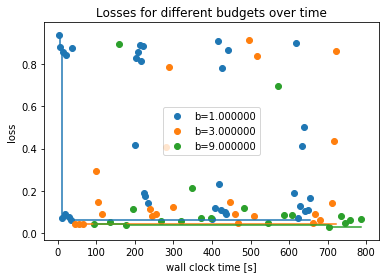

In [133]:
import hpbandster.visualization as hpvis

all_runs = result.get_all_runs()
id2conf = result.get_id2config_mapping()

First let's see, if we really can evaluate more configurations when makeing use of low budget runs.

**Task:** Plot the finished runs over time. How many runs per minute did finish for the individual budgets (only approximately)? (1point)

**Answer:** **TODO** 1 epoch: $1.8$ runs per minute, 3 epochs: $1.1$ runs per minute, 9 epochs: $0.8$ runs per minute

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcc4d4d5128>)

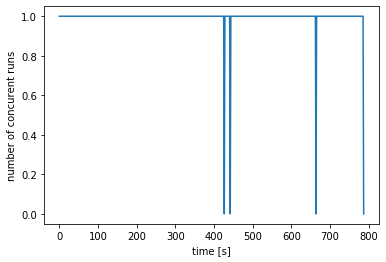

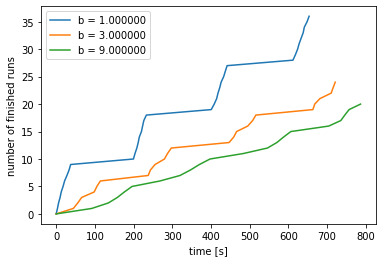

In [134]:
# START TODO ##################
hpvis.concurrent_runs_over_time(runs=all_runs)
# and the number of finished runs.
hpvis.finished_runs_over_time(runs=all_runs)

# raise NotImplementedError

Evaluating configurations on lower budgets doesn't make sense - even if they are faster - if the performance ranking isn't consistent from low to high budget. This means, that the loss rankings for configurations should correlate. In simplified terms: The best configuration after one epoch should also be the best after nine epochs, the second best should stay the second best and so on.

**Task:** Plot correlations of rankings across budgets. Are the correlations high enough? (1point)

**Answer:** **TODO** The first step from 1 to 3 epochs makes sense, with a correlation of $0.90$. The others still correlate with $0.82$ and $0.66$.

14:07:19 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fcc4d55fc50>
14:07:19 Using auto colorbar locator on colorbar
14:07:19 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fcc4d55fc50>
14:07:19 Setting pcolormesh


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcc4d635048>)

14:07:19 not adjusting title pos because a title was already placed manually: 1.050000
14:07:19 findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
14:07:19 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
14:07:19 findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 1.05
14:07:19 findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
14:07:19 findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
14:07:19 findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
14:07:19 findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 0.05
14:07:19 findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
14:07:19 findfont: score(<Font 'cmb10' (cmb10.t

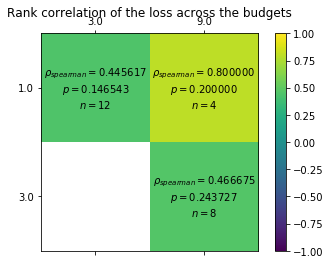

In [132]:
# START TODO ##################
hpvis.correlation_across_budgets(result)
# raise NotImplementedError

We usually assume, that training on a higher budget (number of epochs) and sampling more configurations can lead to better results. Let's check this.

**Task:** Plot the losses over time. Do our assumptions hold true? Why? (1point)

**Answer:** **TODO** Both assumptions hold true. The best evaluation for a budget is increasing for increasing budget. For each budget, the incumbent (lines) is decreasing.   

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc4502278>)

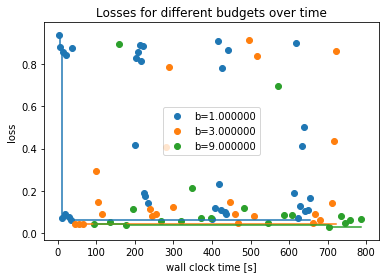

In [135]:
# START TODO ##################
# Let's plot the observed losses grouped by budget,
hpvis.losses_over_time(all_runs)
# raise NotImplementedError

Remember that BOHB uses a model after some time to improve the configuation sampling. We can check, if the BO-sampled configurations work better than the random-sampled.

**Task:** Plot loss histograms for all budgets only with BO-sampled and only with random-sampled configurations (6 histograms). Is the BO-sampling useful? (2points)

**Answer:** **TODO** 

(<Figure size 432x288 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc4d3526a0>,
       dtype=object))

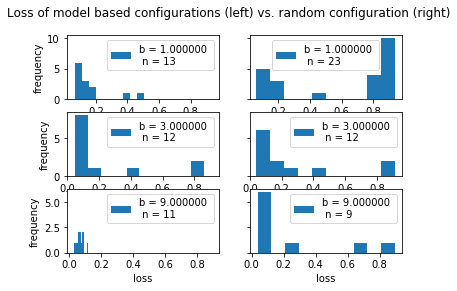

In [136]:
# START TODO ##################
hpvis.performance_histogram_model_vs_random(all_runs, id2conf)
# raise NotImplementedError

### Your Feedback on Exercise 9
